In [1]:
!pip install wheel

  Using cached wheel-0.42.0-py3-none-any.whl (65 kB)


In [8]:
!pip install causal-conv1d==1.0.0

  Using cached causal_conv1d-1.0.0-cp310-cp310-linux_x86_64.whl
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


In [9]:
!pip install mamba-ssm==1.0.1

  Using cached mamba_ssm-1.0.1-cp310-cp310-linux_x86_64.whl
  Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
  Using cached einops-0.7.0-py3-none-any.whl (44 kB)
  Using cached regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl (311 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached safetensors-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tokenizers-0.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)


In [10]:
!pip install ipywidgets

  Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
  Using cached widgetsnbextension-4.0.9-py3-none-any.whl (2.3 MB)


In [11]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-12-18 21:44:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  3.00MB/s    in 0.4s    

2023-12-18 21:44:16 (3.00 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [13]:
!mkdir -p differentattention

In [ ]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
from mamba_ssm import Mamba
#hyperparams
epochs = 100
lr = 1e-3
batch_size = 64
block_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
max_iters = 10000
print_iters = 100
eval_iters = 10
eval_interval = 300
n_embed=384
n_heads = 6
n_layers = 6
dropout = 0.2
# ---------
with open("input.txt", "r") as f:
  text = f.read()

# Unique characters
chars = sorted(list(set(text)))
print(''.join(chars))
vocab_size = len(chars)
print(vocab_size)

#Tokenizers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda xx: [stoi[x] for x in xx]
decode = lambda xx: ''.join([itos[x] for x in xx])
encode("Hello!")
print(decode(encode("Hello!")))


# train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
  # generate targets and context
  if split == "train":
    data = train_data
  else:
    data = val_data
  index = torch.randint(0,len(data)-block_size,(batch_size,))
  x = torch.stack([data[ind:ind+block_size] for ind in index])
  y = torch.stack([data[ind+1:ind+block_size+1] for ind in index])
  return x.to(device),y.to(device)


@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'test']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out


class SelfAttentionHead(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.keys = nn.Linear(n_embed, head_size)
    self.queries = nn.Linear(n_embed, head_size)
    self.values = nn.Linear(n_embed, head_size)
    self.head_size = head_size
    self.n_embed = n_embed
    self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))).to(device))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.keys(x) # (B,T,C_h)
    q = self.queries(x) # (B,T,C_h)
    v = self.values(x) # (B,T,C_h)
    wei = k @ q.transpose(-1,-2) * C**(-0.5)# (B,T,T)
    wei = wei.masked_fill( self.tril[:T,:T]==0, float('-inf'))
    # wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = torch.log(torch.exp(wei)+1) # (B,T,T)
    wei = self.dropout(wei)
    out = wei @ v # (B,T,C_h)
    return out


class LayerNorm(nn.Module):
  def __init__(self, dim) -> None:
    super().__init__()
    self.eps = 1e-5
    # params
    self.gamma = nn.Parameter(torch.ones(dim))
    self.beta = nn.Parameter(torch.zeros(dim))

  def forward(self, x):
    xmean = x.mean(dim=1, keepdim=True)
    xvar = ((x-xmean)**2).mean(dim=1, keepdim=True)
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, head_size) -> None:
    super().__init__()
    self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
    self.proj = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

class FeedForward(nn.Module):
  def __init__(self, n_embed) -> None:
    super().__init__()
    self.ffn = nn.Sequential(
      nn.Linear(n_embed, 4*n_embed),
      nn.ReLU(),
      nn.Linear(4*n_embed, n_embed),
      nn.Dropout(dropout),
    )
  def forward(self, x):
    return self.ffn(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_heads) -> None:
    super().__init__()
    self.head_size = n_embed // n_heads
    # self.sa_head = MultiHeadAttention(n_heads, self.head_size)
    self.sa_head = Mamba(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embed, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
  ).to("cuda")
    self.ffn = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)


  def forward(self, x):
    x = x + self.sa_head(self.ln1(x))
    x = x + self.ffn(self.ln2(x))

    return x

class BigramNeuralNetwork(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size,n_embed)
    self.position_embedding_table = nn.Embedding(block_size,n_embed)
    self.sa_head = MultiHeadAttention(4,int(n_embed/4))
    self.lm_head = nn.Linear(n_embed,vocab_size)
    self.ffn = FeedForward(n_embed)
    self.blocks = nn.Sequential(*[Block(n_embed,n_heads=n_heads) for _ in range(n_layers)])


  def forward(self, idx, targets=None):
    # idx = idx[:,-block_size:]
    B,T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B,T,C_e)
    pos_emb = self.position_embedding_table(torch.arange(T,device=device)) # (T,C_e)
    x = tok_emb + pos_emb # (B,T,C_e)
    x = self.blocks(x) # (B,T,C_e)
    logits = self.lm_head(x) # (B,T,vocab_size)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      logits = logits.view(B,T,C)
    return logits, loss
  def generate(self, idx, max_new_tokens):
    # idx is (B,T)
    idx_next = []
    for i in range(max_new_tokens):
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      last_timestep = logits[:,-1,:]
      probs = F.softmax(last_timestep, dim=1)
      next_index = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_index), dim=1)
    for arr in idx:
      print(decode(arr.cpu().detach().numpy()))
    return idx

model = BigramNeuralNetwork(vocab_size)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
checkpoint_path = None#"./differentattention/model_40.pt"
epoch = 0
if checkpoint_path:
  checkpoint = torch.load(checkpoint_path)
  print(checkpoint)
  if checkpoint['model_state_dict']:
    model.load_state_dict(checkpoint['model_state_dict'].to(device))
  if checkpoint['optimizer_state_dict']:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
device = "cuda"
m = model.to(device)
print("Uses device " + device)
MODEL_CHECKPOINT = "./differentattention/model_{iter}.pt"
losses_data = {"train":[], "test":[]}
for iter in tqdm(range(epoch ,max_iters)):
  if iter % eval_iters == 0:
    losses = estimate_loss()
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")

  if iter % print_iters == 0:
    losses = estimate_loss()
    torch.save({
            'epoch': iter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            }, MODEL_CHECKPOINT.format(iter=iter))
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    model.eval()
    with torch.no_grad():
      #Generate from the model:
      output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device).contiguous(), 1000  )[0].tolist()

    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")
    model.train()

  #Get data
  xb,yb = get_batch("train")

  #Evaluate loss
  logits,loss = model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  torch.nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
torch.save(model.state_dict(), "./differentattention/model.pt")
#Generate from the model:
output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device),1000)[0].tolist()



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
Hello!
Uses device cuda


  0%|                                                                                                                                | 0/10000 [00:00<?, ?it/s]

Step 0, train loss:4.6412, test loss:4.6341


  0%|                                                                                                                     | 1/10000 [00:04<13:21:33,  4.81s/it]



u-J!M.OuQwRyBT:RmTGNjWpxIe!DPAdEZZSbwLDX:GrWu;
RPVsZ!Ml;XUTcePEcqyN.ztQV,vtXDR?,H;3cvFzPctk&Qo!ym'PaOz!
:a,k!fKZ:ddi&YrM,PAV$
yJuUEFZxlBGEZxJrjd!Lo-WE$PpHM!VkBNTc&mC;h3EOw axDqq-LIwVl:Slu &MN,$wRyLc
IjZJwRmdolqlA?e3EnHrSVvbkcZuyR!IoM?SvklEMWEFIuBn?;&jn
M--.IVZ;Xh??.Hq.jlRAM:eT.GUdgLQsx-RGtoARZHDRxjNllsyGgITeqMfxuIIzDegQ:R$RGsvMcjJgrYicauTGMXRZ!g.IxyGyA?.HE&$iZuQ.OqR.;ezZb.HxiGXrSIPADRKfDRy3DRegRzIjlsRa?ZzuhoiOsu?agFR3bSZnRSWtKPJesJKyve
ev?jUAcX
,-LZlRZuIaf
D$GXuIJRXT
ePV&3bSiDRHuSQroIS$jJKHlXeaIvHZ.fzYIYRiUMbRW$ZuM3gg?MkvfShn!CEumfSJNKae
HGTkKAh-
,lk,X'GuZIgK'lc'CeiuD
Zb?A&K'fTQeG
eaaxQZPAa'Ia.VwryAZQ'cZXR
llnGicqGR'GeNCZyZeIGXgWOZsSgoZpcDh-rna
IRNXGX.XDReuwrI,
UTuzDIgiRETRycRGUKsceSSIaT?DACT
T
fZxRGhIsgNV.'A3$eENfJZW.VD.Z
eItQZOl?qWNZR3wPDKHja'ThMqKNcrDRSIaGcD
lNsNRZn$s&SI.fH''egZXIOXfozfCe
B.:ko!D
ekXG
,aA;GD
D
Ise'GvShMeRfXVuOl?yG
yAaZ.KJfHj.IfPhKAVWbeVwH!IEFe3AtSJD;SADF.f!,OkcaIuAfuN,MlN
Gregx.NiWIsVH:ZOlM.zggDV$?pJiglSZX.ZuTIGMG.VkeR$;o
IeYrWR,VW!ZuRIM.zDeItRU?ERM';elW$eIJfV&Iht

  0%|▏                                                                                                                      | 12/10000 [00:06<47:33,  3.50it/s]

Step 10, train loss:2.8636, test loss:2.8849


  0%|▎                                                                                                                      | 22/10000 [00:07<29:59,  5.54it/s]

Step 20, train loss:2.3168, test loss:2.3445


  0%|▍                                                                                                                      | 32/10000 [00:08<27:18,  6.08it/s]

Step 30, train loss:2.0825, test loss:2.1283


  0%|▍                                                                                                                      | 42/10000 [00:09<27:01,  6.14it/s]

Step 40, train loss:1.9429, test loss:2.0221


  1%|▌                                                                                                                      | 52/10000 [00:10<26:48,  6.18it/s]

Step 50, train loss:1.8240, test loss:1.9568


  1%|▋                                                                                                                      | 62/10000 [00:12<26:44,  6.19it/s]

Step 60, train loss:1.7517, test loss:1.9417


  1%|▊                                                                                                                      | 72/10000 [00:13<26:38,  6.21it/s]

Step 70, train loss:1.6906, test loss:1.8901


  1%|▉                                                                                                                      | 82/10000 [00:14<26:46,  6.18it/s]

Step 80, train loss:1.6513, test loss:1.8445


  1%|█                                                                                                                      | 92/10000 [00:15<26:47,  6.17it/s]

Step 90, train loss:1.6026, test loss:1.7990


  1%|█▏                                                                                                                    | 100/10000 [00:16<15:55, 10.36it/s]

Step 100, train loss:1.5672, test loss:1.7751


  1%|█▏                                                                                                                  | 102/10000 [00:21<2:13:58,  1.23it/s]



BRUTUS:
Naure haw anged, bovicia-bose of his some of his,
The heirle him: he complance mosses; your genting, and blothing she
now to elde of Your conformen this which dip 'tis fight three 's might
And your gods and thou?

BRompany?

CATESBY:
I craven my it do her we have Menamen I would
King and her Bask:
Breceties oven as act, how conqueats of conscate. But faulty; unberchan be,
And are that your father. Shall not in thou reldfing hind
How that man's to't now chave your Rome.
3gbreaks you
shall take bobs stool Ricencher schwered, swifter To starn. Cleen this despect on, kille
To been and withal whost. I day carwer!
And be not me free men,
Valland made stouch then event.
To do roub off, and do revol! my contin,
Citizen:
Thy have by kink!'
Shall the justices be the volder .
Now now that Cyeather of hour,
That squess and come is my besench octain pity
As 'way a servy chain!
Give thy fendful to.

GORUCHIDA:
Go, if antoouther; as magine.

ROMEO:
What I do atful voice the forthout he.

RI

  1%|█▎                                                                                                                    | 112/10000 [00:22<45:06,  3.65it/s]

Step 110, train loss:1.5301, test loss:1.7533


  1%|█▍                                                                                                                    | 122/10000 [00:23<30:11,  5.45it/s]

Step 120, train loss:1.5088, test loss:1.7461


  1%|█▌                                                                                                                    | 132/10000 [00:25<27:39,  5.95it/s]

Step 130, train loss:1.4902, test loss:1.7257


  1%|█▋                                                                                                                    | 142/10000 [00:26<27:11,  6.04it/s]

Step 140, train loss:1.4613, test loss:1.6948


  2%|█▊                                                                                                                    | 152/10000 [00:27<27:17,  6.02it/s]

Step 150, train loss:1.4459, test loss:1.6857


  2%|█▉                                                                                                                    | 162/10000 [00:28<27:20,  6.00it/s]

Step 160, train loss:1.4261, test loss:1.6574


  2%|██                                                                                                                    | 172/10000 [00:30<27:29,  5.96it/s]

Step 170, train loss:1.4210, test loss:1.6215


  2%|██▏                                                                                                                   | 182/10000 [00:31<27:25,  5.96it/s]

Step 180, train loss:1.4024, test loss:1.6171


  2%|██▎                                                                                                                   | 192/10000 [00:32<27:27,  5.95it/s]

Step 190, train loss:1.3755, test loss:1.6276


  2%|██▎                                                                                                                   | 200/10000 [00:33<16:13, 10.06it/s]

Step 200, train loss:1.3783, test loss:1.6154


  2%|██▎                                                                                                                 | 202/10000 [00:38<2:09:42,  1.26it/s]



CLARENCE:
Conspirator purpose to only talks, and my fellow to kill
Counteousing. And devior up the ciruse maid.

KING RICHARD III:
But she bare, I love you a gentlious queen, in enger'd
For I think of a dured her cause; I was king Read
With teven away; I day by Again.

JULIET:
Ay! I rot with the Duke of Ruch and such do wry.

ANGELO:
SICINIUS:
Where love you a right?

VOLUMNIA:
Your great commending heavy against have me,
That love I subject to the bell! all?

All:
Not give to; the, ill'd, prive that our know,
What's War all too much her stay ! would there's are before
From my tongue than; ere abroad of her bear must
Inteed's cap of all mistres palk'st respect.

NORTHUMBERLAND:
I ready or blick against, and More commons.

LADY ANNE:
We'll take thee all her knee, a stage mether, venom and too;
Jull there scome leave mortly saw's none.

SICINIUS:
'Tis no touch no mark'd not
The told thy become of a Rumble, unsingal.

DUKE VINCENTIO:
Were by the warm'd by kneeth to accond:
'Fis Lord, wh

  2%|██▌                                                                                                                   | 212/10000 [00:39<44:33,  3.66it/s]

Step 210, train loss:1.3624, test loss:1.6376


  2%|██▌                                                                                                                   | 222/10000 [00:40<30:22,  5.36it/s]

Step 220, train loss:1.3437, test loss:1.6097


  2%|██▋                                                                                                                   | 232/10000 [00:42<28:02,  5.81it/s]

Step 230, train loss:1.3362, test loss:1.6264


  2%|██▊                                                                                                                   | 242/10000 [00:43<27:39,  5.88it/s]

Step 240, train loss:1.3312, test loss:1.5893


  3%|██▉                                                                                                                   | 252/10000 [00:44<27:32,  5.90it/s]

Step 250, train loss:1.3077, test loss:1.6213


  3%|███                                                                                                                   | 262/10000 [00:46<27:43,  5.85it/s]

Step 260, train loss:1.2952, test loss:1.6029


  3%|███▏                                                                                                                  | 272/10000 [00:47<27:41,  5.86it/s]

Step 270, train loss:1.2943, test loss:1.5776


  3%|███▎                                                                                                                  | 282/10000 [00:48<27:50,  5.82it/s]

Step 280, train loss:1.2900, test loss:1.5623


  3%|███▍                                                                                                                  | 292/10000 [00:49<27:44,  5.83it/s]

Step 290, train loss:1.2737, test loss:1.5651


  3%|███▌                                                                                                                  | 300/10000 [00:50<16:23,  9.87it/s]

Step 300, train loss:1.2607, test loss:1.5931


  3%|███▌                                                                                                                | 302/10000 [00:55<2:08:37,  1.26it/s]



CAMILLO:
Gentlemen,
Which lengtom the few, you valiant presence.

PAULINA:
My mab patience is it out.

TRANIO:
Mighter of Gloucester; visiting soldiers,
To do the termitancies of this drovening,
When you may changing, you be not swear than we here
not tell my hands that is this pipers broke!

Fcolot!

SLY:
Come for a trust to by Gloucester, steal freegements.

ROMEO:
Your feeding heart, I saw to shape some married.

ISABELLA:
I am yonder'd in him: I have not myself might do you to command,
Of Julits all they will appear time please.
Good curse the Romeo to spark commit chwards being
Our great childrens times. Thereto me, Geolend, filght all glory our tribles;
Twelve at a mind; but not claim, gentling the
soul still wanton, who gates all, die, that is not never
And men on him: what once mine,'d in our curstion,
Give me the geor of Warwick's emfect to engross,
Alio we justify to my advocate,
Clerusagely scurrunken bids my son, likes on
This bearing what you stand, though defend down up

  3%|███▋                                                                                                                  | 312/10000 [00:56<44:30,  3.63it/s]

Step 310, train loss:1.2544, test loss:1.5801


  3%|███▊                                                                                                                  | 322/10000 [00:57<30:34,  5.28it/s]

Step 320, train loss:1.2435, test loss:1.5592


  3%|███▉                                                                                                                  | 332/10000 [00:59<28:10,  5.72it/s]

Step 330, train loss:1.2380, test loss:1.5503


  3%|████                                                                                                                  | 342/10000 [01:00<27:52,  5.77it/s]

Step 340, train loss:1.2239, test loss:1.5508


  4%|████▏                                                                                                                 | 352/10000 [01:01<27:41,  5.81it/s]

Step 350, train loss:1.2240, test loss:1.5625


  4%|████▎                                                                                                                 | 362/10000 [01:03<27:49,  5.77it/s]

Step 360, train loss:1.2125, test loss:1.5608


  4%|████▍                                                                                                                 | 372/10000 [01:04<27:49,  5.77it/s]

Step 370, train loss:1.2085, test loss:1.5458


  4%|████▌                                                                                                                 | 382/10000 [01:05<27:49,  5.76it/s]

Step 380, train loss:1.2045, test loss:1.5931


  4%|████▋                                                                                                                 | 392/10000 [01:07<27:45,  5.77it/s]

Step 390, train loss:1.1928, test loss:1.5985


  4%|████▋                                                                                                                 | 400/10000 [01:07<16:24,  9.75it/s]

Step 400, train loss:1.1896, test loss:1.5773


  4%|████▋                                                                                                               | 402/10000 [01:12<2:02:57,  1.30it/s]



DUCHESS OF YORK:
For Warwick, like justice; Let my proper son:
Thy new-be pack'd one what which he I shall well,
I change the fault of it. This is almost
aothousand man do make my soul:
That once be he speak.

GLOUCESTER:
I would buy false for fight:
But I, I beseech you guard that stay your days?

KING RICHARD III:
Through I saw conspiracious search'd you?

ELBOW:
Richmond, clear, I pray you, and all deaths as your
interchange and receive on the caust: a
presently giving itself showled of my servants,
thievests famaining upon this action.

QUEEN MARGARET:
Henry, less our scause.

KING RICHARD III:
Christian's death;
Pray you, we do worship with caust!
I would those would not take his presense and staught
A hundred many a sebjoin'd with him.

SAMPSON:
'Cate your chaving south'd and crapted the ugcle
That being indeed.

POLIXENES:
Miscarry; I wander'd stay to bitter;
For she is strange not railiff have an ountent,
To let him as this.

CAPULET:
More than the cunning those hands must me

  4%|████▊                                                                                                                 | 412/10000 [01:13<43:41,  3.66it/s]

Step 410, train loss:1.1695, test loss:1.5521


  4%|████▉                                                                                                                 | 422/10000 [01:15<30:29,  5.24it/s]

Step 420, train loss:1.1793, test loss:1.5888


  4%|█████                                                                                                                 | 432/10000 [01:16<28:29,  5.60it/s]

Step 430, train loss:1.1664, test loss:1.5552


  4%|█████▏                                                                                                                | 442/10000 [01:17<28:00,  5.69it/s]

Step 440, train loss:1.1646, test loss:1.5598


  5%|█████▎                                                                                                                | 452/10000 [01:19<27:56,  5.70it/s]

Step 450, train loss:1.1424, test loss:1.5953


  5%|█████▍                                                                                                                | 462/10000 [01:20<28:01,  5.67it/s]

Step 460, train loss:1.1324, test loss:1.5870


  5%|█████▌                                                                                                                | 472/10000 [01:21<28:03,  5.66it/s]

Step 470, train loss:1.1370, test loss:1.6014


  5%|█████▋                                                                                                                | 482/10000 [01:23<28:05,  5.65it/s]

Step 480, train loss:1.1192, test loss:1.5808


  5%|█████▊                                                                                                                | 492/10000 [01:24<28:06,  5.64it/s]

Step 490, train loss:1.1267, test loss:1.5940


  5%|█████▉                                                                                                                | 500/10000 [01:25<16:36,  9.54it/s]

Step 500, train loss:1.1002, test loss:1.5910


  5%|█████▊                                                                                                              | 502/10000 [01:29<2:01:34,  1.30it/s]



QUEEN:
Ay, and that's possess and hands upon him;
If she that sits make him depart but that
Which shall hear these and faults, that merciful arm,
With sent conceit nor threats of virtues,
Would prove a larking report, and therefore,
His daughter lip, that the unnatural pines
Draven a perpetual gangerous error in:
It is, it is no greater fantastic several cracks,
Come, in that dangerously will not, by me in it:
Therefore aurn in that touch thy brother bellion,
But thou the noble Northumberland,
Why arthorn most wert to chase the 'For that is frown.

VIRGILIA:
Now, billy the conduct. Worms you are a Right?
Lie, unringly love and schoolmaster? purses
Pass that outward back to the heart? What do you gone,
That thou shalt not scape! Therefore snain to pips of king:
I am a cretch shall not strange selfarks for in water
Was ever melting on this presecrit.--pitch'd mind
And fellow our sutfif that ballied farther pvellar me,
Afthe unscruption't, sleep, having not the neck open
That were bases

  5%|██████                                                                                                                | 512/10000 [01:31<43:27,  3.64it/s]

Step 510, train loss:1.1045, test loss:1.6203


  5%|██████▏                                                                                                               | 522/10000 [01:32<30:23,  5.20it/s]

Step 520, train loss:1.0846, test loss:1.6233


  5%|██████▎                                                                                                               | 532/10000 [01:33<28:11,  5.60it/s]

Step 530, train loss:1.0845, test loss:1.6140


  5%|██████▍                                                                                                               | 542/10000 [01:35<27:53,  5.65it/s]

Step 540, train loss:1.0826, test loss:1.6126


  6%|██████▌                                                                                                               | 552/10000 [01:36<27:55,  5.64it/s]

Step 550, train loss:1.0813, test loss:1.6390


  6%|██████▋                                                                                                               | 562/10000 [01:37<27:49,  5.65it/s]

Step 560, train loss:1.0633, test loss:1.6296


  6%|██████▋                                                                                                               | 572/10000 [01:39<27:49,  5.65it/s]

Step 570, train loss:1.0520, test loss:1.6920


  6%|██████▊                                                                                                               | 582/10000 [01:40<27:53,  5.63it/s]

Step 580, train loss:1.0469, test loss:1.6403


  6%|██████▉                                                                                                               | 592/10000 [01:41<27:55,  5.62it/s]

Step 590, train loss:1.0378, test loss:1.6526


  6%|███████                                                                                                               | 600/10000 [01:42<16:32,  9.47it/s]

Step 600, train loss:1.0271, test loss:1.6826


  6%|██████▉                                                                                                             | 602/10000 [01:47<2:12:12,  1.18it/s]



RICHARD:
Qind thereby good and entertainment:
Therefore, were well approved by disloyal lips:
And for that for this royalty lord choken
Arms to command the Duke of Hereford, Duked blemish.
To HENRYluing God's vanour, I her, both are attain.
Ah, Hugh, angerbers, to live time soon,
And, as are beamen to sweet as I should, cheer so
Do the applaud the issue. O, the sea-sick, I may she--
Away, let not be just on thee, father.
There is that to help you return?

PETRUCHIO:
All burns for this wit, and not her love.
Was crown have often bosom, echolity
Doth not noble and report him between
They came not only, and anon it, provinction;
Nothing but to raiment and follow'd the sea
And flatterest baby and in their name this time?
Was not Richmond in that blown his lible.
Boy! then, their that is thy humble thing,
So woe thee well why who's this torments live?
Why, they told her, and this I know him out of;
Asking their furgeor.

SICINIUS:
What, which our own leave?

BRUTUS:
The other taught as ha

  6%|███████▏                                                                                                              | 612/10000 [01:48<45:17,  3.45it/s]

Step 610, train loss:1.0245, test loss:1.6777


  6%|███████▎                                                                                                              | 622/10000 [01:50<30:34,  5.11it/s]

Step 620, train loss:1.0008, test loss:1.7058


  6%|███████▍                                                                                                              | 632/10000 [01:51<28:14,  5.53it/s]

Step 630, train loss:1.0068, test loss:1.7259


  6%|███████▌                                                                                                              | 642/10000 [01:52<27:49,  5.61it/s]

Step 640, train loss:0.9982, test loss:1.6873


  7%|███████▋                                                                                                              | 652/10000 [01:54<27:48,  5.60it/s]

Step 650, train loss:0.9830, test loss:1.7093


  7%|███████▊                                                                                                              | 662/10000 [01:55<27:46,  5.60it/s]

Step 660, train loss:0.9650, test loss:1.6925


  7%|███████▉                                                                                                              | 672/10000 [01:57<27:51,  5.58it/s]

Step 670, train loss:0.9677, test loss:1.7265


  7%|████████                                                                                                              | 682/10000 [01:58<27:47,  5.59it/s]

Step 680, train loss:0.9473, test loss:1.7590


  7%|████████▏                                                                                                             | 692/10000 [01:59<27:46,  5.58it/s]

Step 690, train loss:0.9419, test loss:1.7627


  7%|████████▎                                                                                                             | 700/10000 [02:00<16:24,  9.45it/s]

Step 700, train loss:0.9350, test loss:1.7377


  7%|████████▏                                                                                                           | 702/10000 [02:05<2:03:38,  1.25it/s]



CLARENCE:
These rather were my true lost for the traitor's hand.
Their love I would not have thee dead,
To come to her fearful voices too bad,
And charge them troops of fdmiral tongues;
And were potions sunshine that art thou there,
Ah, who separation thus senseless-skews,
To make my poor instate with that souls;
Thine only for the silent upon thyself,
To sullen with thunder straight deputy,
To stain the greater glory to wash the
Tower in the tremble: out, an some punished
To some equally mine exaplaing;
So many growit to make my veins,
Yet are more in grave beholding trembs,
That sounds not likews, or a soldier's hand,
That cause to make service am strange;
Who sues his queen, but two is most be,
The mouse of choice in his sun, being jot,
To trust them into my soul with John;
And, make that wilt know, this shertain quarrels
Do Jeson. The woe, sunce.

LADY CAPULET:
Where is the king?

GLOUCESTER:

KATHARINA:
'Twere it well for a scouldy: but it choose a frighter,
Nor of all these wou

  7%|████████▍                                                                                                             | 712/10000 [02:06<43:47,  3.53it/s]

Step 710, train loss:0.9269, test loss:1.7299


  7%|████████▌                                                                                                             | 722/10000 [02:07<30:23,  5.09it/s]

Step 720, train loss:0.9349, test loss:1.7997


  7%|████████▋                                                                                                             | 732/10000 [02:09<28:08,  5.49it/s]

Step 730, train loss:0.9253, test loss:1.8602


  7%|████████▊                                                                                                             | 742/10000 [02:10<27:44,  5.56it/s]

Step 740, train loss:0.8998, test loss:1.7795


  8%|████████▊                                                                                                             | 752/10000 [02:12<27:43,  5.56it/s]

Step 750, train loss:0.9032, test loss:1.7988


  8%|████████▉                                                                                                             | 762/10000 [02:13<27:37,  5.57it/s]

Step 760, train loss:0.8859, test loss:1.8106


  8%|█████████                                                                                                             | 772/10000 [02:14<27:39,  5.56it/s]

Step 770, train loss:0.8718, test loss:1.8337


  8%|█████████▏                                                                                                            | 782/10000 [02:16<27:44,  5.54it/s]

Step 780, train loss:0.8495, test loss:1.8351


  8%|█████████▎                                                                                                            | 792/10000 [02:17<27:39,  5.55it/s]

Step 790, train loss:0.8371, test loss:1.8749


  8%|█████████▍                                                                                                            | 800/10000 [02:18<16:19,  9.39it/s]

Step 800, train loss:0.8465, test loss:1.8588


  8%|█████████▎                                                                                                          | 802/10000 [02:22<1:58:40,  1.29it/s]



LEONTES:
Did you got history in the city.
Is now no vinour of his timeless sounds,
How weep's tent; and long as seen his reasons,
Letters your highness to Ansorrey me.

KING HENRY VI:
How I prison!--
I am wedded that did for his fand fall.
Should enjoy, be gone, so foul a poor an
opening the post that glory. So,
ere we the  our works and attended to be a
stch-viled in ground? Oven in the winds and drows
common pity gentleman: butchers, as I said,
Respects back, in breathing in the east,
He hath given against us rid his earth,
With one, whiles, hisart him not his country.

LEONTES:
What now!
Good night, good grant!

LEONTES:
Make the absence is not the countenand
Till she had the conduct to earth to teach?

PAULINA:
You guest, not smell with her;
But how then may dismutation swords, and good,
To go with him shut misdoth gried in hell.
This shows are true.

MENENIUS:
The one whom partoken in the villain
Of all the way: we say you consent to Wolshian
I would beg instruct his person. Mus

  8%|█████████▌                                                                                                            | 812/10000 [02:24<42:46,  3.58it/s]

Step 810, train loss:0.8271, test loss:1.8996


  8%|█████████▋                                                                                                            | 822/10000 [02:25<30:03,  5.09it/s]

Step 820, train loss:0.8331, test loss:1.8762


  8%|█████████▊                                                                                                            | 832/10000 [02:26<27:53,  5.48it/s]

Step 830, train loss:0.8073, test loss:1.9451


  8%|█████████▉                                                                                                            | 842/10000 [02:28<27:35,  5.53it/s]

Step 840, train loss:0.7970, test loss:1.8876


  9%|██████████                                                                                                            | 852/10000 [02:29<27:33,  5.53it/s]

Step 850, train loss:0.7919, test loss:1.9661


  9%|██████████▏                                                                                                           | 862/10000 [02:31<27:29,  5.54it/s]

Step 860, train loss:0.7771, test loss:1.9709


  9%|██████████▎                                                                                                           | 872/10000 [02:32<27:29,  5.53it/s]

Step 870, train loss:0.7652, test loss:1.9989


  9%|██████████▍                                                                                                           | 882/10000 [02:33<27:34,  5.51it/s]

Step 880, train loss:0.7626, test loss:1.9903


  9%|██████████▌                                                                                                           | 892/10000 [02:35<27:34,  5.51it/s]

Step 890, train loss:0.7633, test loss:2.0039


  9%|██████████▌                                                                                                           | 900/10000 [02:35<16:12,  9.36it/s]

Step 900, train loss:0.7284, test loss:2.0123


  9%|██████████▍                                                                                                         | 902/10000 [02:40<1:58:47,  1.28it/s]



LEONTES:
Why, so you come, gentlemen!
The first I suddese have been doing the world,
Unto the waters of your own belly;
Or and we, not veen here it is.
Here comes his golden heart is but one:
Rest you now, when such fanish'd wife,
Whose sealto's glad, till bafford lightning have.
First, though is overthrow without erral the foe,
Unto'st thou that hear thee heaven forbid
Acceed their own flowers they.

BRUTUS:
I aim'd such tells you.

VOLUMNIA:
I am had, though they did but oney it.

VALERCENTIO:
O sir, look upon this day that I, brother,
That he did please your leisure seem,
Does not that Bolingbroke.

CORIOLANUS:
Go thou away:
How change their mother gave at thy near doth grieve
At thy dame till is this, and sway too late?
Nothing she be, thy son and heart will not
Thmus lend me thy play'd: wyilty didst thou, dread I,
Razeant thee, child, perhaps, well thither, present,
For conscent I am as seat as those,
Travelling my fresh wind in commons.

DUKE VINCENTIO:
'Tis this there, by your

  9%|██████████▊                                                                                                           | 912/10000 [02:41<42:40,  3.55it/s]

Step 910, train loss:0.7517, test loss:2.0231


  9%|██████████▉                                                                                                           | 922/10000 [02:43<29:54,  5.06it/s]

Step 920, train loss:0.7299, test loss:2.0449


  9%|██████████▉                                                                                                           | 932/10000 [02:44<27:46,  5.44it/s]

Step 930, train loss:0.7170, test loss:2.0471


  9%|███████████                                                                                                           | 942/10000 [02:46<27:24,  5.51it/s]

Step 940, train loss:0.7126, test loss:2.0932


 10%|███████████▏                                                                                                          | 952/10000 [02:47<27:22,  5.51it/s]

Step 950, train loss:0.6944, test loss:2.0961


 10%|███████████▎                                                                                                          | 962/10000 [02:48<27:23,  5.50it/s]

Step 960, train loss:0.6742, test loss:2.1328


 10%|███████████▍                                                                                                          | 972/10000 [02:50<27:22,  5.50it/s]

Step 970, train loss:0.6894, test loss:2.1251


 10%|███████████▌                                                                                                          | 982/10000 [02:51<27:21,  5.49it/s]

Step 980, train loss:0.6548, test loss:2.1240


 10%|███████████▋                                                                                                          | 992/10000 [02:52<27:20,  5.49it/s]

Step 990, train loss:0.6719, test loss:2.1070


 10%|███████████▋                                                                                                         | 1000/10000 [02:53<16:01,  9.36it/s]

Step 1000, train loss:0.6380, test loss:2.1667


 10%|███████████▌                                                                                                       | 1002/10000 [02:58<1:55:47,  1.30it/s]



PAULINA:
Sir, lo, my lord.

PERDITA:
Even he shall thing o'er her new-beloved,
To be redomption kept her beheld their woes,
O'er lawyers; and then for Clarence is so
It:
But when your fault to do some powlers could not
Like socies, or I'll determine of any wits
are pleasant.

LUCIO:
Carnall!

ISCENTIO:
The your lassas with his state should be put
ful vauntlerenity. What copes our norse with her
they vunsported and neather club; never correct,
With this once coll with clipping, and he comes
Where these shrering holy curse hath been,
Nor shall be well.

CORIOLANUS:
I do but queen them not?

LADY CAPULET:
We have.

CLAUDIO:
As well as London, take the crown.

ISABELLA:
O give leave!
And his son?

CLAUDIO:
One word, Lord Salisbury
She loves me chief, deace to the greater.
Gentlemen, let's along.

Provost:
Hypardon'd heart
Above her breedings, eardy see anon.

LUCIO:
Nay, not for death; guess what hand was her.
Please you, lords; give I heard from the crown.
Look, and be a word: if I fear

 10%|███████████▊                                                                                                         | 1012/10000 [02:59<41:58,  3.57it/s]

Step 1010, train loss:0.6395, test loss:2.1644


 10%|███████████▉                                                                                                         | 1022/10000 [03:00<29:37,  5.05it/s]

Step 1020, train loss:0.6138, test loss:2.2191


 10%|████████████                                                                                                         | 1032/10000 [03:02<27:32,  5.43it/s]

Step 1030, train loss:0.6328, test loss:2.1601


 10%|████████████▏                                                                                                        | 1042/10000 [03:03<27:11,  5.49it/s]

Step 1040, train loss:0.6170, test loss:2.2282


 11%|████████████▎                                                                                                        | 1052/10000 [03:05<27:08,  5.50it/s]

Step 1050, train loss:0.6061, test loss:2.2674


 11%|████████████▍                                                                                                        | 1062/10000 [03:06<27:11,  5.48it/s]

Step 1060, train loss:0.5970, test loss:2.3055


 11%|████████████▌                                                                                                        | 1072/10000 [03:07<27:07,  5.49it/s]

Step 1070, train loss:0.5866, test loss:2.2973


 11%|████████████▋                                                                                                        | 1082/10000 [03:09<27:05,  5.49it/s]

Step 1080, train loss:0.5850, test loss:2.2667


 11%|████████████▊                                                                                                        | 1092/10000 [03:10<27:05,  5.48it/s]

Step 1090, train loss:0.5657, test loss:2.3266


 11%|████████████▊                                                                                                        | 1100/10000 [03:11<15:54,  9.32it/s]

Step 1100, train loss:0.5602, test loss:2.3292


 11%|████████████▋                                                                                                      | 1102/10000 [03:15<1:54:42,  1.29it/s]



PICINIUS:
Let me but speak.

CORIOLANUS:
Tyrelable what.

BRUTUS:
Ay, say'st thou the Marcius?

BRUTUS:
Not so sofn to tongue and heart
To hear the king.

CORIOLANUS:
Measurel Clarence!

CORIOLANUS:
I wish't poor i' the people.

BRUTUS:
Go, you consent to-morrow.

SICINIUS:
You have ever can.

SICINIUS:
As I Richard
Whilst, then?

Messenger:
They should have slept affected him to the hill.

SICINIUS:
'Tis his tewth
As wisdom the people, which I damn'd in them;
Have done with Juliet and it.

CORIOLANUS:
I do beseech your husband.

MARCIUS:
My noble lords. I do not say 'thrive our own,'
And one word ' I saw to hell: and my grow would smell
Were come to me a mistress' man? how it
will I rose the loss! If thou wilt be hoped to-night
And feast, I have the mother stands,
Whose hate her have and maid'd to troubled friends.
Brother, why promised the hours of wreath, I cry thee.
My loving Lord Baptista's daughter hold,
That from his sister boils being enthralled as become
As Jew's partier eye

 11%|█████████████                                                                                                        | 1112/10000 [03:17<41:37,  3.56it/s]

Step 1110, train loss:0.5569, test loss:2.3428


 11%|█████████████▏                                                                                                       | 1122/10000 [03:18<29:23,  5.04it/s]

Step 1120, train loss:0.5480, test loss:2.3724


 11%|█████████████▏                                                                                                       | 1132/10000 [03:20<27:18,  5.41it/s]

Step 1130, train loss:0.5339, test loss:2.3547


 11%|█████████████▎                                                                                                       | 1142/10000 [03:21<26:57,  5.48it/s]

Step 1140, train loss:0.5210, test loss:2.4182


 12%|█████████████▍                                                                                                       | 1152/10000 [03:22<26:52,  5.49it/s]

Step 1150, train loss:0.5154, test loss:2.4370


 12%|█████████████▌                                                                                                       | 1162/10000 [03:24<26:52,  5.48it/s]

Step 1160, train loss:0.5315, test loss:2.4219


 12%|█████████████▋                                                                                                       | 1172/10000 [03:25<26:51,  5.48it/s]

Step 1170, train loss:0.5142, test loss:2.5085


 12%|█████████████▊                                                                                                       | 1182/10000 [03:27<26:51,  5.47it/s]

Step 1180, train loss:0.4950, test loss:2.4731


 12%|█████████████▉                                                                                                       | 1192/10000 [03:28<26:51,  5.47it/s]

Step 1190, train loss:0.4874, test loss:2.4639


 12%|██████████████                                                                                                       | 1200/10000 [03:29<15:47,  9.29it/s]

Step 1200, train loss:0.4709, test loss:2.4762


 12%|█████████████▊                                                                                                     | 1202/10000 [03:33<1:53:31,  1.29it/s]



BENVOLIO:
Tybalt, sovereign, when a sovereign close which
and point! his chival gentleman born befall'n King Edward.

BUCKINGHAM:
Fortune and Gloucester's death, nor Hereford,
As he consent his death English gild disige,
Take the wars of York. That hast thou never will
The squiet out of first, his instantly makes
Enexter the matter to his beavery tongue
And make his spalling ropurating tize,
And he's in courtier steps and men,
With magistness of his charge his stamp'd,
And I, as he valianted a speak at a
second his friends with a vain. The steal tard
up full of this formall; whose fearful spirit,
An ounterfeit stands, and levelves men leave!

ENRUCHIO:
Very sorrow to my guilty murder was.

HORTENSIO:
Sir, my woman of virtue fellows,
She slips to me no surfeit and malice and
will give me joy my dug breaks and groans
May move you to pure in some saping father;
Why give you an you then were flint en it speak?
Nor did you speak not for it: O, hear you none.

Abot:
Meeter:
I'll tell you w

 12%|██████████████▏                                                                                                      | 1212/10000 [03:35<41:22,  3.54it/s]

Step 1210, train loss:0.4746, test loss:2.5109


 12%|██████████████▎                                                                                                      | 1222/10000 [03:36<29:18,  4.99it/s]

Step 1220, train loss:0.4784, test loss:2.5880


 12%|██████████████▍                                                                                                      | 1232/10000 [03:37<27:18,  5.35it/s]

Step 1230, train loss:0.4665, test loss:2.5944


 12%|██████████████▌                                                                                                      | 1242/10000 [03:39<26:53,  5.43it/s]

Step 1240, train loss:0.4489, test loss:2.5772


 13%|██████████████▋                                                                                                      | 1252/10000 [03:40<26:47,  5.44it/s]

Step 1250, train loss:0.4493, test loss:2.6524


 13%|██████████████▊                                                                                                      | 1262/10000 [03:42<26:53,  5.42it/s]

Step 1260, train loss:0.4460, test loss:2.6992


 13%|██████████████▉                                                                                                      | 1272/10000 [03:43<26:51,  5.42it/s]

Step 1270, train loss:0.4277, test loss:2.6901


 13%|██████████████▉                                                                                                      | 1282/10000 [03:44<26:49,  5.42it/s]

Step 1280, train loss:0.4166, test loss:2.6816


 13%|███████████████                                                                                                      | 1292/10000 [03:46<26:50,  5.41it/s]

Step 1290, train loss:0.4230, test loss:2.7087


 13%|███████████████▏                                                                                                     | 1300/10000 [03:46<15:43,  9.22it/s]

Step 1300, train loss:0.4130, test loss:2.7082


 13%|██████████████▉                                                                                                    | 1302/10000 [03:51<1:52:45,  1.29it/s]



ELBOW:
Great kinsman! young men, the lady winger gates!
Here comes his majesty to sa hard that it speaks:
Sometime she hath been debating thee;
She hath sot down, or kiln-hathless rancour
With old enemy in fortune.

PERDITA:
Now Jove afford you cause!
To thee of those that have been I am not?

LUCENTIO:
Sirrah, no more! none are but sees any thing:
Grandsire goes, thou knows when thou art:
Tyball men will burn shed to be to stray away?

JULIET:
Ay, but thou dream not of thy care suit.

JULIET:
Balm hither can I straw a strange must
Belike a gloyal batches: who look you all
I am not done; sweet Mammift them
Am a bank to be pronounce there.

BUCKINGHAM:
Say that I intent to do;
It were a better play the eyil sight;
And so do I love thee to be treaded upon
A banish'd rude belly falling wars
Since Warwick bad of wicked earth.
And, as go on marriage with a tender
Although they be oppreited in the business,
Not charging the day, is my bondered light
Unto to an hours servite to a gossip,
Go

 13%|███████████████▎                                                                                                     | 1312/10000 [03:53<40:52,  3.54it/s]

Step 1310, train loss:0.4018, test loss:2.7142


 13%|███████████████▍                                                                                                     | 1322/10000 [03:54<28:47,  5.02it/s]

Step 1320, train loss:0.3984, test loss:2.8198


 13%|███████████████▌                                                                                                     | 1332/10000 [03:55<26:46,  5.40it/s]

Step 1330, train loss:0.4014, test loss:2.7927


 13%|███████████████▋                                                                                                     | 1342/10000 [03:57<26:28,  5.45it/s]

Step 1340, train loss:0.3937, test loss:2.8119


 14%|███████████████▊                                                                                                     | 1352/10000 [03:58<26:22,  5.47it/s]

Step 1350, train loss:0.3917, test loss:2.8035


 14%|███████████████▉                                                                                                     | 1362/10000 [03:59<26:22,  5.46it/s]

Step 1360, train loss:0.3771, test loss:2.8817


 14%|████████████████                                                                                                     | 1372/10000 [04:01<26:20,  5.46it/s]

Step 1370, train loss:0.3663, test loss:2.8538


 14%|████████████████▏                                                                                                    | 1382/10000 [04:02<26:20,  5.45it/s]

Step 1380, train loss:0.3691, test loss:2.8163


 14%|████████████████▎                                                                                                    | 1392/10000 [04:04<26:17,  5.46it/s]

Step 1390, train loss:0.3695, test loss:2.9404


 14%|████████████████▍                                                                                                    | 1400/10000 [04:04<15:30,  9.25it/s]

Step 1400, train loss:0.3656, test loss:2.8705


 14%|████████████████                                                                                                   | 1402/10000 [04:09<1:51:04,  1.29it/s]



WARWICK:
Edward will we here, were hard like a lady:
And revenue is dead, and I'll be sworn brother.

KING HENRY VI:
The lords are nobleness of my carest, and that
Witness so bound in have but little scout and away.
Nay, since we such guide toise do mourn to discrease.

GLOUCESTER:
Yes, I know this attend you were, faith.

HASTINGS:
My lord, this most good man of you.

DUKE VINCENTIO:
There was a word;
But make his entrails of unbarnal man:
He is much reguiles of the state with her
To save these little thoughts, I then was thought,
And with their hearts for and duty bier!

QUEEN:
This is strange: methinks it were a very gross
kind of a thing, well-halling, So;
I am content: a bawdle'f believe-knightly
Which then blows have wrong'd Richard's friends.
I saw the quickland for revenge,
Until the king set on that sorrow's ear.
Fir Menrach vellet.

BRUTUS:
Could she have eat cred the air of mercy,
And shakes the sea full of tears that wretch
Thou shalt deserve to him.

First Servingman:
Na

 14%|████████████████▌                                                                                                    | 1412/10000 [04:10<40:30,  3.53it/s]

Step 1410, train loss:0.3488, test loss:2.8971


 14%|████████████████▋                                                                                                    | 1422/10000 [04:12<28:35,  5.00it/s]

Step 1420, train loss:0.3440, test loss:2.8162


 14%|████████████████▊                                                                                                    | 1432/10000 [04:13<26:40,  5.35it/s]

Step 1430, train loss:0.3632, test loss:2.9511


 14%|████████████████▊                                                                                                    | 1442/10000 [04:15<26:21,  5.41it/s]

Step 1440, train loss:0.3418, test loss:2.9514


 15%|████████████████▉                                                                                                    | 1452/10000 [04:16<26:16,  5.42it/s]

Step 1450, train loss:0.3314, test loss:2.9519


 15%|█████████████████                                                                                                    | 1462/10000 [04:17<26:14,  5.42it/s]

Step 1460, train loss:0.3203, test loss:3.0073


 15%|█████████████████▏                                                                                                   | 1472/10000 [04:19<26:14,  5.42it/s]

Step 1470, train loss:0.3222, test loss:3.0323


 15%|█████████████████▎                                                                                                   | 1482/10000 [04:20<26:14,  5.41it/s]

Step 1480, train loss:0.3193, test loss:3.0351


 15%|█████████████████▍                                                                                                   | 1492/10000 [04:22<26:16,  5.40it/s]

Step 1490, train loss:0.3034, test loss:3.0278


 15%|█████████████████▌                                                                                                   | 1500/10000 [04:22<15:20,  9.23it/s]

Step 1500, train loss:0.3028, test loss:3.0384


 15%|█████████████████▎                                                                                                 | 1502/10000 [04:27<1:50:04,  1.29it/s]



SICINIUS:
Have a cause to go by charm
Be still then; and more incense their time
When I weep fault I was respected with
Hurn bag and yet a brain: but we part of him
As that the present portal general
Will be best beside: he wangs are he for
Alack the world, an a fool in the sun
And dies of heaven, and devour such a noble
And a thousand straight to close thy sons,
Death hath thyself to scorn us to turn the gift?
Which once the soft killing? O fool! I think of
recover her honour; 'tis not ten thoughts of our last;
and then to crave a widow of their liking
That victory my boars and clubs: them go
To him that ere entered and make cries out
Most audible, even from his propose to the
entrails, and cried upon the anrich stamp'ds of knowledge!
Make poor pounds! o' the earth, they do change thempelves
As much as man's as heaven as my nature:
Doth not then my life, how shall we do?
Are so holds up Lancagiance, and with me
Therefore, if absolute shall never could tell
When he does bear her prop

 15%|█████████████████▋                                                                                                   | 1512/10000 [04:28<39:52,  3.55it/s]

Step 1510, train loss:0.3022, test loss:3.0609


 15%|█████████████████▊                                                                                                   | 1522/10000 [04:30<28:08,  5.02it/s]

Step 1520, train loss:0.3050, test loss:3.0879


 15%|█████████████████▉                                                                                                   | 1532/10000 [04:31<26:08,  5.40it/s]

Step 1530, train loss:0.3029, test loss:3.0978


 15%|██████████████████                                                                                                   | 1542/10000 [04:32<25:51,  5.45it/s]

Step 1540, train loss:0.3090, test loss:3.1222


 16%|██████████████████▏                                                                                                  | 1552/10000 [04:34<25:48,  5.45it/s]

Step 1550, train loss:0.2953, test loss:3.1740


 16%|██████████████████▎                                                                                                  | 1562/10000 [04:35<25:43,  5.47it/s]

Step 1560, train loss:0.2925, test loss:3.1510


 16%|██████████████████▍                                                                                                  | 1572/10000 [04:37<25:45,  5.45it/s]

Step 1570, train loss:0.2851, test loss:3.1492


 16%|██████████████████▌                                                                                                  | 1582/10000 [04:38<25:45,  5.45it/s]

Step 1580, train loss:0.2811, test loss:3.1867


 16%|██████████████████▋                                                                                                  | 1592/10000 [04:39<25:44,  5.44it/s]

Step 1590, train loss:0.2849, test loss:3.1801


 16%|██████████████████▋                                                                                                  | 1600/10000 [04:40<15:09,  9.23it/s]

Step 1600, train loss:0.2756, test loss:3.1963


 16%|██████████████████▍                                                                                                | 1602/10000 [04:45<1:48:27,  1.29it/s]



JULIET:
Yet let me know the best.

ROMEO:
Tybalt, the bloodce of the mother's pardon.

First Soldier:
Fear not, frowns, we'll make consul.

First Senator:
Now, sir, come.

MENENIUS:
Has not honest men; let him come down hour:
Speak, Clifford, will you fiel him working.

Second Murderer:
A!ull as he be?

First Murderer:
Then he hath sprungess the rock in the him.

Choler:
You live your honour, play is fulfed about
To pluck out of thy chair. Go, come to me;
And, if you conceal it so?

BRAKENBURY:
Ay, my lord. God forgive my sins, and bid and cere
Clifford for his mercy was or world hence;
Put in the courage out look upon, and discords me
and me will so much that my soul they have:
If the king perfect danger that he forsworn
At any he did behind himself with him,
The rumour and his present portance of their
febborn, the nobles of the pars that can grows! The
duke's in our nothing which he justs in one.

KING LEWIS XI:
But stay apt o'ercome to kept it; for with us,
Taking wastes' violenc

 16%|██████████████████▊                                                                                                  | 1612/10000 [04:46<39:22,  3.55it/s]

Step 1610, train loss:0.2772, test loss:3.2627


 16%|██████████████████▉                                                                                                  | 1622/10000 [04:48<27:47,  5.02it/s]

Step 1620, train loss:0.2651, test loss:3.2423


 16%|███████████████████                                                                                                  | 1632/10000 [04:49<25:48,  5.41it/s]

Step 1630, train loss:0.2634, test loss:3.2522


 16%|███████████████████▏                                                                                                 | 1642/10000 [04:50<25:30,  5.46it/s]

Step 1640, train loss:0.2715, test loss:3.2421


 17%|███████████████████▎                                                                                                 | 1652/10000 [04:52<25:31,  5.45it/s]

Step 1650, train loss:0.2594, test loss:3.2775


 17%|███████████████████▍                                                                                                 | 1662/10000 [04:53<25:27,  5.46it/s]

Step 1660, train loss:0.2585, test loss:3.2910


 17%|███████████████████▌                                                                                                 | 1672/10000 [04:54<25:29,  5.45it/s]

Step 1670, train loss:0.2587, test loss:3.3190


 17%|███████████████████▋                                                                                                 | 1682/10000 [04:56<25:27,  5.45it/s]

Step 1680, train loss:0.2453, test loss:3.3223


 17%|███████████████████▊                                                                                                 | 1692/10000 [04:57<25:25,  5.45it/s]

Step 1690, train loss:0.2556, test loss:3.2668


 17%|███████████████████▉                                                                                                 | 1700/10000 [04:58<15:00,  9.22it/s]

Step 1700, train loss:0.2502, test loss:3.3180


 17%|███████████████████▌                                                                                               | 1702/10000 [05:03<1:47:12,  1.29it/s]



NORTHUMBERLAND:
The news is very fair and good, my lord:
Richard not far from hence hath hid his head.

DUKE OF YORK:
'Tis but thy name is Elbow: come all then.

KING EDWARD IV:
If thou be men, I fear thy conspiracy,
Or like a guest nor call me hence in thee.

LADY ANNE:
O just, alandy! mock me, good comfort!
For every pelper than the wind ather man.
Qome trust I may be well: be content'd for the gillytake,
With those guests and then they changed's eldest soul.
For them they love they have under them, but rule forth
A call'd in downright and bereaven here in them
Against the tyrannous and the third in the world
To seek the eagle, who day discontented
In every precious pervices that he
Does not that war strength in the heard a licol!
You shall have none ill, sir?

FLORIZEL:
And fires said the gown of her our king,
With whom the beauty arithment and from her
As easy dear Juliet's given, here;
It should be thine.

CAMILLO:
He's gracious silence, how deadly son!

BUSHY:
And that is needf

 17%|████████████████████                                                                                                 | 1712/10000 [05:04<38:51,  3.55it/s]

Step 1710, train loss:0.2402, test loss:3.3912


 17%|████████████████████▏                                                                                                | 1722/10000 [05:05<27:26,  5.03it/s]

Step 1720, train loss:0.2342, test loss:3.4143


 17%|████████████████████▎                                                                                                | 1732/10000 [05:07<25:32,  5.40it/s]

Step 1730, train loss:0.2340, test loss:3.3839


 17%|████████████████████▍                                                                                                | 1742/10000 [05:08<25:14,  5.45it/s]

Step 1740, train loss:0.2424, test loss:3.4052


 18%|████████████████████▍                                                                                                | 1752/10000 [05:10<25:11,  5.46it/s]

Step 1750, train loss:0.2319, test loss:3.3728


 18%|████████████████████▌                                                                                                | 1762/10000 [05:11<25:10,  5.45it/s]

Step 1760, train loss:0.2306, test loss:3.4194


 18%|████████████████████▋                                                                                                | 1772/10000 [05:12<25:10,  5.45it/s]

Step 1770, train loss:0.2209, test loss:3.4487


 18%|████████████████████▊                                                                                                | 1782/10000 [05:14<25:11,  5.44it/s]

Step 1780, train loss:0.2333, test loss:3.4771


 18%|████████████████████▉                                                                                                | 1792/10000 [05:15<25:07,  5.44it/s]

Step 1790, train loss:0.2207, test loss:3.4721


 18%|█████████████████████                                                                                                | 1800/10000 [05:16<14:47,  9.24it/s]

Step 1800, train loss:0.2252, test loss:3.5692


 18%|████████████████████▋                                                                                              | 1802/10000 [05:20<1:45:32,  1.29it/s]



BRUTUS:
Why then should you find us unbuilded?

SICINIUS:
Hath set the desire of the people?

CORIOLANUS:
That which I did weep myn for the lists,
Both feeding, greet I thee, make to my ear,
No heart's
Than they are mine, even young men thrive work
And am your fellow Tranio in your mouth:
Tranio is spoken, in the power lost
What Cled with the warlike Surrey sleward
Most the tale to send him still refient
Whil'er the sea put of his house, sir,
Can change the sweet with his speed so farth.

HENRY BOLINGBROKE:
What men mads be?

DUKE OF YORK:
To great merchant of remember who bids my state.

KING RICHARD II:
Hark ye, your Romeo will change you all are and mine?

JOHN OF GAUNT:
To take is to fare.
Thy head is weary at 'scape:'
And thereto make Oxwomt mine own Lord of reposing,
Bade's well to Brcome it on my love:
Sir, Tybalt is granted no more but than mine,
Who is as from me and cheer execution.
As that talk of cares their gentle parks
In this on my faith and honour, to make his,
And ma

 18%|█████████████████████▏                                                                                               | 1812/10000 [05:22<38:25,  3.55it/s]

Step 1810, train loss:0.2127, test loss:3.4760


 18%|█████████████████████▎                                                                                               | 1822/10000 [05:23<27:07,  5.03it/s]

Step 1820, train loss:0.2208, test loss:3.5483


 18%|█████████████████████▍                                                                                               | 1832/10000 [05:25<25:12,  5.40it/s]

Step 1830, train loss:0.2164, test loss:3.5766


 18%|█████████████████████▌                                                                                               | 1842/10000 [05:26<24:52,  5.47it/s]

Step 1840, train loss:0.2169, test loss:3.5472


 19%|█████████████████████▋                                                                                               | 1852/10000 [05:27<24:47,  5.48it/s]

Step 1850, train loss:0.2121, test loss:3.4649


 19%|█████████████████████▊                                                                                               | 1862/10000 [05:29<24:48,  5.47it/s]

Step 1860, train loss:0.2111, test loss:3.5499


 19%|█████████████████████▉                                                                                               | 1872/10000 [05:30<24:46,  5.47it/s]

Step 1870, train loss:0.2198, test loss:3.6149


 19%|██████████████████████                                                                                               | 1882/10000 [05:31<24:52,  5.44it/s]

Step 1880, train loss:0.2070, test loss:3.6255


 19%|██████████████████████▏                                                                                              | 1892/10000 [05:33<24:50,  5.44it/s]

Step 1890, train loss:0.2098, test loss:3.5311


 19%|██████████████████████▏                                                                                              | 1900/10000 [05:34<14:35,  9.25it/s]

Step 1900, train loss:0.2069, test loss:3.5404


 19%|█████████████████████▊                                                                                             | 1902/10000 [05:38<1:46:17,  1.27it/s]



KING merrily.

SICINIUS:
Go tell the people:
You will have you do it kindly with the citizens,
Lest you behold the bell: speak it again.

CORIOLANUS:
I did not I, her:
But my arms and banish'd Engarants
That they they do not knowledge. By the poor
Perchance is letter; or the king's water
May be rough w'd a fearful fly: and swallow me
The lads and given to one for either swords,
But meet anon, take almost stole,
That mistake the hollow of the Antiates
That when he may dighter away the drops!
Give me another was, and justified
Who is in Romeo!

PAULINGS:
Was ever king so far I may give;
But he, as thou hast object me, thy kind woose,
Her only that I  murder'd my soul's hand
Being blank'stable there affriction.
Made him in Bore to Laura Untant,
The Lord of Somerset, which stand I account
'Tis strength without it, at what discourtesy,
Where be shive befiex the hard way with the gazing.

ROMEO:
But sound'?

BENVOlD:
What counsel on my head, what wouldst thou had
My wardly entreaty to my k

 19%|██████████████████████▎                                                                                              | 1912/10000 [05:40<38:17,  3.52it/s]

Step 1910, train loss:0.2025, test loss:3.6660


 19%|██████████████████████▍                                                                                              | 1922/10000 [05:41<26:50,  5.02it/s]

Step 1920, train loss:0.2037, test loss:3.6182


 19%|██████████████████████▌                                                                                              | 1932/10000 [05:42<24:54,  5.40it/s]

Step 1930, train loss:0.2005, test loss:3.6247


 19%|██████████████████████▋                                                                                              | 1942/10000 [05:44<24:34,  5.46it/s]

Step 1940, train loss:0.2044, test loss:3.6667


 20%|██████████████████████▊                                                                                              | 1952/10000 [05:45<24:32,  5.46it/s]

Step 1950, train loss:0.1972, test loss:3.6283


 20%|██████████████████████▉                                                                                              | 1962/10000 [05:47<24:32,  5.46it/s]

Step 1960, train loss:0.1924, test loss:3.6955


 20%|███████████████████████                                                                                              | 1972/10000 [05:48<24:32,  5.45it/s]

Step 1970, train loss:0.1933, test loss:3.6993


 20%|███████████████████████▏                                                                                             | 1982/10000 [05:49<24:31,  5.45it/s]

Step 1980, train loss:0.1945, test loss:3.7001


 20%|███████████████████████▎                                                                                             | 1992/10000 [05:51<24:30,  5.45it/s]

Step 1990, train loss:0.1945, test loss:3.6753


 20%|███████████████████████▍                                                                                             | 2000/10000 [05:51<14:27,  9.22it/s]

Step 2000, train loss:0.1852, test loss:3.7454


 20%|███████████████████████                                                                                            | 2002/10000 [05:56<1:44:26,  1.28it/s]



Pursuivant.
Welcome, Clifford, pitiful truggest-malchion--where
I thought thou shalt make that I must excuse.
I thought it myself in hazards too much.
There is my purse to commit me masking:
any, it were stand upon our arraign toe!--
In graceZ-phead had menril, arbour of resolved.
Most mighty, if justify have I unto the Tower.
Prepare thy slaughter'd, and thou shalt quive thither
To gnaw these robes encounters, which slew makes unquish'd.

GLOUCESTER:
He that bereft thee, lady, of thy husband,
Did it to help thee to a better husband.
Have I thought long to see thy life and thy belong
Are on thy mother's name is ringest daughter
'Pardon' should be 'longing the king's life.

FRIAR LAURENCE:
The duty is dead; and yet it within the hand that
loved his body.

LEONTES:
Good Paulina,
Who hast the memory of Hermione,
I know, in honour, O, that e'er I
Had squared me to the course! Why dost thou say King Richard?
My dear-loving too, my peace is made.

LADY ANNE:
Name to joy; but I will not hea

 20%|███████████████████████▌                                                                                             | 2012/10000 [05:58<37:38,  3.54it/s]

Step 2010, train loss:0.1854, test loss:3.7874


 20%|███████████████████████▋                                                                                             | 2022/10000 [05:59<26:29,  5.02it/s]

Step 2020, train loss:0.1875, test loss:3.7611


 20%|███████████████████████▊                                                                                             | 2032/10000 [06:00<24:36,  5.40it/s]

Step 2030, train loss:0.1866, test loss:3.7532


 20%|███████████████████████▉                                                                                             | 2042/10000 [06:02<24:17,  5.46it/s]

Step 2040, train loss:0.1843, test loss:3.7868


 21%|████████████████████████                                                                                             | 2052/10000 [06:03<24:11,  5.47it/s]

Step 2050, train loss:0.1855, test loss:3.7406


 21%|████████████████████████▏                                                                                            | 2062/10000 [06:04<24:11,  5.47it/s]

Step 2060, train loss:0.1823, test loss:3.8491


 21%|████████████████████████▏                                                                                            | 2072/10000 [06:06<24:12,  5.46it/s]

Step 2070, train loss:0.1854, test loss:3.8220


 21%|████████████████████████▎                                                                                            | 2082/10000 [06:07<24:08,  5.47it/s]

Step 2080, train loss:0.1799, test loss:3.7562


 21%|████████████████████████▍                                                                                            | 2092/10000 [06:09<24:10,  5.45it/s]

Step 2090, train loss:0.1778, test loss:3.8388


 21%|████████████████████████▌                                                                                            | 2100/10000 [06:09<14:10,  9.29it/s]

Step 2100, train loss:0.1801, test loss:3.8091


 21%|████████████████████████▏                                                                                          | 2102/10000 [06:14<1:47:45,  1.22it/s]



ESCALUS:
How would you live, Pompey? by being a bawd? What
was a bawd to give great that he is at hand?

LEONTES:
A Harry Bolingbroke.

PAULINA:
You have done to him?

Provost:
None, since. Can you, sir, come him less your converses; be
thine own contents.

CORIOLANUS:
Give me thy hand: Come.

Second Servingman:
I' the matter: pray you, sir, look your birth.

CORIOLANUS:
The gods begin to mock me.

CORIOLANUS:
True, so I am.

Third STINGS:
A fellow.

Clown:
Pray your tent.

CORIOLANUS:
So then to me?

SICINIUS:
No, sweet faction, now.

CORIOLANUS:
So the next me i'?

LARTIUS:
O,
'Tis so: and the heart will fly to our own in.

Citizens:
The king's name changes, envey'd at Milfort; for thou
Turn great to see his lustter and the king;
Commend them and condemn'd to himself.

First Senator:
My father's maid and his mind:
The very liquid can rage; and then to any he
What victory Warwick's bones. I beseech thee
My misery hath terrible conceited
To say extremities with you of such ang
So man

 21%|████████████████████████▋                                                                                            | 2112/10000 [06:16<37:57,  3.46it/s]

Step 2110, train loss:0.1748, test loss:3.8881


 21%|████████████████████████▊                                                                                            | 2122/10000 [06:17<26:12,  5.01it/s]

Step 2120, train loss:0.1792, test loss:3.8422


 21%|████████████████████████▉                                                                                            | 2132/10000 [06:18<24:13,  5.41it/s]

Step 2130, train loss:0.1753, test loss:3.8770


 21%|█████████████████████████                                                                                            | 2142/10000 [06:20<23:55,  5.47it/s]

Step 2140, train loss:0.1771, test loss:3.8839


 22%|█████████████████████████▏                                                                                           | 2152/10000 [06:21<23:52,  5.48it/s]

Step 2150, train loss:0.1721, test loss:3.8270


 22%|█████████████████████████▎                                                                                           | 2162/10000 [06:23<23:55,  5.46it/s]

Step 2160, train loss:0.1749, test loss:3.8860


 22%|█████████████████████████▍                                                                                           | 2172/10000 [06:24<23:50,  5.47it/s]

Step 2170, train loss:0.1746, test loss:3.8538


 22%|█████████████████████████▌                                                                                           | 2182/10000 [06:25<23:54,  5.45it/s]

Step 2180, train loss:0.1740, test loss:3.9448


 22%|█████████████████████████▋                                                                                           | 2192/10000 [06:27<23:54,  5.44it/s]

Step 2190, train loss:0.1717, test loss:3.8785


 22%|█████████████████████████▋                                                                                           | 2200/10000 [06:27<14:03,  9.24it/s]

Step 2200, train loss:0.1702, test loss:3.9362


 22%|█████████████████████████▎                                                                                         | 2202/10000 [06:32<1:40:50,  1.29it/s]



First Citizen:
By heaven, I will part his country: so do you
what your good worship in your country's good?

Third Citizen:
Nay, you say the prayers from the Volsces stand in summer
In private; as 'twere a break of rage!
Here where you firmly a Roman?

First Roman:
Therefore the day fight: bid him leaden spirit
To mortal toward him choose to lay my suot.

Nurse:

Nurse:
Well, you are leave to meet the devil.
Welcome, good Mercutio, thou but R have the
dole-ent a brawling drink: I like not light.

RIVERS:
Were I am committed. Good my lords,
I' the war, yet shall short it is the business.

QUEEN MARGARET:
So part we sadly in this troublous world,
To merite how to love the bed:
I have new brother, hearing any longer.

GLOUCESTER:
He that bereft them let the vile that grine
That he doth see all discords reverce:
Unspeak no more.

PRINCE EDWARD:
I know it clutverle, will think--but I will not
Judden by my soul thou overheardine
With cloth of great death.

BENVOLIO:
There lies sure Romeo's

 22%|█████████████████████████▉                                                                                           | 2212/10000 [06:33<36:35,  3.55it/s]

Step 2210, train loss:0.1717, test loss:3.9673


 22%|█████████████████████████▉                                                                                           | 2222/10000 [06:35<25:47,  5.03it/s]

Step 2220, train loss:0.1662, test loss:3.9051


 22%|██████████████████████████                                                                                           | 2232/10000 [06:36<23:59,  5.39it/s]

Step 2230, train loss:0.1691, test loss:3.9318


 22%|██████████████████████████▏                                                                                          | 2242/10000 [06:38<23:41,  5.46it/s]

Step 2240, train loss:0.1687, test loss:3.9220


 23%|██████████████████████████▎                                                                                          | 2252/10000 [06:39<23:40,  5.45it/s]

Step 2250, train loss:0.1651, test loss:4.0176


 23%|██████████████████████████▍                                                                                          | 2262/10000 [06:40<23:36,  5.46it/s]

Step 2260, train loss:0.1653, test loss:4.0157


 23%|██████████████████████████▌                                                                                          | 2272/10000 [06:42<23:34,  5.46it/s]

Step 2270, train loss:0.1701, test loss:3.9519


 23%|██████████████████████████▋                                                                                          | 2282/10000 [06:43<23:35,  5.45it/s]

Step 2280, train loss:0.1654, test loss:3.9181


 23%|██████████████████████████▊                                                                                          | 2292/10000 [06:45<23:33,  5.45it/s]

Step 2290, train loss:0.1633, test loss:3.9893


 23%|██████████████████████████▉                                                                                          | 2300/10000 [06:45<13:50,  9.27it/s]

Step 2300, train loss:0.1671, test loss:4.0502


 23%|██████████████████████████▍                                                                                        | 2302/10000 [06:50<1:40:20,  1.28it/s]



LEONTES:
You, Lord Buckingham; am for your part,
Like to die, with myself as good act!
Then thieve to justice hath hid a thoughts on
To do him good: obehin me to all this when
Throng the admiral and to be wild, I warrant a
royal prince agree with old fearful us
Wert enough to shame the field I so very live,
Since suffer'd me from me to know our due of disin
Was stance to age, but in angue four.

QUEEN MARGARET:
Great least one of those world they said that hath done.

HENRY BOLINGBROKE:
As dissolute done, I have thee still thy entreaty
and give dire in their stooping the fishes and
the third the isve to come.

First Servant:
Prevenge you, I have it for my three years
I saw the accuser from the ground.

KING RICHARD II:
How long shall I behold thee?

Page:
My lord, stand back, and virtue not my speed;
Dorse son, our state is a garm there with his light.

DUKE OF AUMERLE:
Who sets me else? by his faces are gone.
Then if Henry lives  one gracious Grey,
And of their vushion, like a deed 

 23%|███████████████████████████                                                                                          | 2312/10000 [06:51<36:09,  3.54it/s]

Step 2310, train loss:0.1613, test loss:3.9638


 23%|███████████████████████████▏                                                                                         | 2322/10000 [06:53<25:28,  5.02it/s]

Step 2320, train loss:0.1594, test loss:3.9592


 23%|███████████████████████████▎                                                                                         | 2332/10000 [06:54<23:38,  5.41it/s]

Step 2330, train loss:0.1585, test loss:3.9879


 23%|███████████████████████████▍                                                                                         | 2342/10000 [06:55<23:23,  5.46it/s]

Step 2340, train loss:0.1582, test loss:3.9302


 24%|███████████████████████████▌                                                                                         | 2352/10000 [06:57<23:18,  5.47it/s]

Step 2350, train loss:0.1568, test loss:3.9910


 24%|███████████████████████████▋                                                                                         | 2362/10000 [06:58<23:18,  5.46it/s]

Step 2360, train loss:0.1550, test loss:4.0365


 24%|███████████████████████████▊                                                                                         | 2372/10000 [07:00<23:15,  5.46it/s]

Step 2370, train loss:0.1586, test loss:4.0673


 24%|███████████████████████████▊                                                                                         | 2382/10000 [07:01<23:16,  5.46it/s]

Step 2380, train loss:0.1561, test loss:4.0990


 24%|███████████████████████████▉                                                                                         | 2392/10000 [07:02<23:12,  5.46it/s]

Step 2390, train loss:0.1556, test loss:4.0426


 24%|████████████████████████████                                                                                         | 2400/10000 [07:03<13:38,  9.28it/s]

Step 2400, train loss:0.1562, test loss:4.0483


 24%|███████████████████████████▌                                                                                       | 2402/10000 [07:08<1:38:58,  1.28it/s]



OXFORD:
What men of heaven, what a jealousies so hit
That this relevy makes the English crown?
And yet why not?

DUKE OF YORK:
Thou fond mad many friends upon the world:
Ay, if thou be there is an egg,
Before thy father gage of all day.
3 KING HENRY VI

QUEEN MARGARET:
Great lords, wise men ne'er sit and wail their loss,
But send him on his knees tedious night.

KING HENRY VI:
Sweet Oxford, away respects these days;
Comeo will I be my consent in my wounds.

WARWICK:
It news, my lord: what can do you think?

KING HENRY VI:
O post, my lord! what news abroad?

HORTENSIO:
How dost thou love your honour will be content?

NORTHUMBERLAND:
First, heaven is Marcius to Richard's throne,
A lip of judgment all about;
For emy his great scolding fathers from been,
The impression of king in lovers' terms,
Come to the person and reigning in the clouds,
And chief the watch be sent from their day.

BUSHY:
The better for our fair without logs, and there packin,
In the man be holp made that ever we shed

 24%|████████████████████████████▏                                                                                        | 2412/10000 [07:09<35:53,  3.52it/s]

Step 2410, train loss:0.1572, test loss:4.0368


 24%|████████████████████████████▎                                                                                        | 2422/10000 [07:11<25:19,  4.99it/s]

Step 2420, train loss:0.1486, test loss:4.0724


 24%|████████████████████████████▍                                                                                        | 2432/10000 [07:12<23:32,  5.36it/s]

Step 2430, train loss:0.1513, test loss:4.0750


 24%|████████████████████████████▌                                                                                        | 2442/10000 [07:13<23:16,  5.41it/s]

Step 2440, train loss:0.1546, test loss:4.0152


 25%|████████████████████████████▋                                                                                        | 2452/10000 [07:15<23:15,  5.41it/s]

Step 2450, train loss:0.1534, test loss:4.1453


 25%|████████████████████████████▊                                                                                        | 2462/10000 [07:16<23:14,  5.41it/s]

Step 2460, train loss:0.1548, test loss:4.1023


 25%|████████████████████████████▉                                                                                        | 2472/10000 [07:18<23:12,  5.41it/s]

Step 2470, train loss:0.1522, test loss:4.0844


 25%|█████████████████████████████                                                                                        | 2482/10000 [07:19<23:11,  5.40it/s]

Step 2480, train loss:0.1539, test loss:4.0144


 25%|█████████████████████████████▏                                                                                       | 2492/10000 [07:20<23:10,  5.40it/s]

Step 2490, train loss:0.1533, test loss:4.0910


 25%|█████████████████████████████▎                                                                                       | 2500/10000 [07:21<13:33,  9.22it/s]

Step 2500, train loss:0.1497, test loss:4.0964


 25%|████████████████████████████▊                                                                                      | 2502/10000 [07:26<1:43:01,  1.21it/s]



AUTOLYCUS:

Clown:
Down with my kind to one that did place you?

Shepherd:
Take him out and fair alliabine much better.

Second Servingman:
A marvellous proclaim a banisform to the
solemnity, here 'tis time, from the end that
loves another. Another he had protector's for
theTestuading and honesty is harms.

Lord:
take him up to wail; and, as I hear, the
duke, I wake him to reapen the curse his will?

QUEEN MARGARET:
What, dost thou scorn me for my gentle counsel?
And soothe the divine And death, now knows you think
Might thus change my dukedom, change it seems
Because their names when their teeth begins.
Here are us Lorden makes of kings and nobles.
Good man to make her good man that she is well,
Good quickly granted tender lady.

GLOUCESTER:
Brother, the Tower, of Smiles one so gross,
To gratulate the ghost. Let gio's paws,
And therefore I will entertain great degree,
And say 'Will't;' in with them great enemy.'
Have you been seen them against the groat;
And if they feel themselves 

 25%|█████████████████████████████▍                                                                                       | 2512/10000 [07:27<36:07,  3.46it/s]

Step 2510, train loss:0.1506, test loss:4.0962


 25%|█████████████████████████████▌                                                                                       | 2522/10000 [07:29<24:51,  5.02it/s]

Step 2520, train loss:0.1481, test loss:4.2083


 25%|█████████████████████████████▌                                                                                       | 2532/10000 [07:30<22:59,  5.41it/s]

Step 2530, train loss:0.1524, test loss:4.0967


 25%|█████████████████████████████▋                                                                                       | 2542/10000 [07:32<22:42,  5.47it/s]

Step 2540, train loss:0.1469, test loss:4.0845


 26%|█████████████████████████████▊                                                                                       | 2552/10000 [07:33<22:40,  5.48it/s]

Step 2550, train loss:0.1481, test loss:4.1260


 26%|█████████████████████████████▉                                                                                       | 2562/10000 [07:34<22:38,  5.47it/s]

Step 2560, train loss:0.1469, test loss:4.1678


 26%|██████████████████████████████                                                                                       | 2572/10000 [07:36<22:39,  5.46it/s]

Step 2570, train loss:0.1491, test loss:4.1365


 26%|██████████████████████████████▏                                                                                      | 2582/10000 [07:37<22:39,  5.46it/s]

Step 2580, train loss:0.1476, test loss:4.0947


 26%|██████████████████████████████▎                                                                                      | 2592/10000 [07:38<22:38,  5.45it/s]

Step 2590, train loss:0.1490, test loss:4.1234


 26%|██████████████████████████████▍                                                                                      | 2600/10000 [07:39<13:18,  9.27it/s]

Step 2600, train loss:0.1478, test loss:4.1779


 26%|█████████████████████████████▉                                                                                     | 2602/10000 [07:44<1:37:48,  1.26it/s]



KING RICHARD III:
But in your daughter's womb I believe
He speaks not stapp'd jottentle, not to repleast,
But you must have your brother by your fond,
None men of this sea, I'll bring you.

DUKE VINCENTIO:
I believe thee, Vrial. My care is grown
from marrying with the wolfares: were metters and
discourted both to repant me with such mage.

CLARENCE:
My chows with sweet soldiers patent the queen,
Because so well; be gone.

CLARENCE:
I shall well bething all things fair days
Hath not our brother dies 'Riners.

CORIOLANUS:
You bless me, gods!

AUFIDIUS:
Therefore, most absolute sir, if thou wilt have
The leading heir of this sleep?

BUCKINGHAM:
Ay, if thou wert call'd our fortune in my breast,
Wheel'd runations for this land's lawful king!
Pale, Master Froth, let our neighbord;
But yet I would not, heavens shall have your feast.

TYBALT:
Thou that Paulina's subject sworns made unknown
As too should implore a fool.

BISHOPHARD IV:
Clarence and scorn: so please you to march
Those till at 

 26%|██████████████████████████████▌                                                                                      | 2612/10000 [07:45<34:59,  3.52it/s]

Step 2610, train loss:0.1444, test loss:4.1613


 26%|██████████████████████████████▋                                                                                      | 2622/10000 [07:47<24:30,  5.02it/s]

Step 2620, train loss:0.1457, test loss:4.2564


 26%|██████████████████████████████▊                                                                                      | 2632/10000 [07:48<22:44,  5.40it/s]

Step 2630, train loss:0.1450, test loss:4.1427


 26%|██████████████████████████████▉                                                                                      | 2642/10000 [07:49<22:25,  5.47it/s]

Step 2640, train loss:0.1443, test loss:4.1809


 27%|███████████████████████████████                                                                                      | 2652/10000 [07:51<22:24,  5.47it/s]

Step 2650, train loss:0.1451, test loss:4.1770


 27%|███████████████████████████████▏                                                                                     | 2662/10000 [07:52<22:24,  5.46it/s]

Step 2660, train loss:0.1441, test loss:4.2410


 27%|███████████████████████████████▎                                                                                     | 2672/10000 [07:54<22:20,  5.46it/s]

Step 2670, train loss:0.1441, test loss:4.1586


 27%|███████████████████████████████▍                                                                                     | 2682/10000 [07:55<22:21,  5.46it/s]

Step 2680, train loss:0.1412, test loss:4.1455


 27%|███████████████████████████████▍                                                                                     | 2692/10000 [07:56<22:20,  5.45it/s]

Step 2690, train loss:0.1406, test loss:4.1969


 27%|███████████████████████████████▌                                                                                     | 2700/10000 [07:57<13:07,  9.27it/s]

Step 2700, train loss:0.1401, test loss:4.1676


 27%|███████████████████████████████                                                                                    | 2702/10000 [08:02<1:34:10,  1.29it/s]



LUCIO:
By heart it, my lord; the duke is very paper
sensio, he is privily of remain
Fast foe the present. Was it not the king
Shall there were no longer nor the point.

MARCIUS:
Thomas of the frail of are ploud; and
He wants the place of peace!

Abbot:
And, in this resolution, of the law,
Self-love I been the triumphant king,
It should be so quaintly to the world.
Being in this multitude to the air,
And let the subject see, to make them know
That outward courtesies would gain a' the word:
And thus must we change this robe of vengeance;
Who, treading his oath and what with posts could not
say.

Scrive opent will not--
For, as the case now shall this divine him:
His own impatience now we are show'd
Sole vine than he will show my father where
Come please blows before the walls.

ROMEO:
And if I told you, for the dearest forget
My soul the field proof to the heart.

LEONTES:
Apollo's angry; and therefore, if thou darest.

DUKE VINCENTIO:

Provost:
I know not where to turn: but I had it f

 27%|███████████████████████████████▋                                                                                     | 2712/10000 [08:03<34:20,  3.54it/s]

Step 2710, train loss:0.1403, test loss:4.2928


 27%|███████████████████████████████▊                                                                                     | 2722/10000 [08:04<24:17,  4.99it/s]

Step 2720, train loss:0.1369, test loss:4.2149


 27%|███████████████████████████████▉                                                                                     | 2732/10000 [08:06<22:34,  5.36it/s]

Step 2730, train loss:0.1412, test loss:4.1920


 27%|████████████████████████████████                                                                                     | 2742/10000 [08:07<22:19,  5.42it/s]

Step 2740, train loss:0.1389, test loss:4.2233


 28%|████████████████████████████████▏                                                                                    | 2752/10000 [08:09<22:15,  5.43it/s]

Step 2750, train loss:0.1402, test loss:4.1819


 28%|████████████████████████████████▎                                                                                    | 2762/10000 [08:10<22:16,  5.41it/s]

Step 2760, train loss:0.1427, test loss:4.2264


 28%|████████████████████████████████▍                                                                                    | 2772/10000 [08:11<22:17,  5.40it/s]

Step 2770, train loss:0.1397, test loss:4.1941


 28%|████████████████████████████████▌                                                                                    | 2782/10000 [08:13<22:15,  5.40it/s]

Step 2780, train loss:0.1363, test loss:4.2042


 28%|████████████████████████████████▋                                                                                    | 2792/10000 [08:14<22:16,  5.39it/s]

Step 2790, train loss:0.1369, test loss:4.2187


 28%|████████████████████████████████▊                                                                                    | 2800/10000 [08:15<13:02,  9.21it/s]

Step 2800, train loss:0.1363, test loss:4.2734


 28%|████████████████████████████████▏                                                                                  | 2802/10000 [08:20<1:34:22,  1.27it/s]



LADY ANNE:
Would you have me down with me unhollo's power,
And was embark'd to cross to Burgundy;
And, in my company, my brother Gloucester;
Or wall on you or I am a cup of question,
Whose breast of an infant fords and marking at
The collow the clock that thou look'd on me?
I me old Gaunt is noble father's sine,
But know the inside of your pernicious rage
With purple forced tongues? What will you swear?
Here are the birds of Rome, no more requites must
Be roinnels and causes of my reproof.
Be not to compits my groans with us, if you
would tell the lodgings and tell so we
God: it sleep in joy!

RICHINA:
It is your worship to us,
And with his sequenct.

HENRY BOLINGBROKE:
Five you convey him, when you were here,
And so your fathers come to prison,
As being but a low, and bear my good comfort,
Such as move as ever lose a delighted by
A plot to petter, but endity, and I'll not
Chold we no little but my restored so near.
Go, sign face, my lord! who sackld honey nurse?

Nurse:
I spy like H

 28%|████████████████████████████████▉                                                                                    | 2812/10000 [08:21<34:08,  3.51it/s]

Step 2810, train loss:0.1391, test loss:4.2215


 28%|█████████████████████████████████                                                                                    | 2822/10000 [08:22<24:02,  4.98it/s]

Step 2820, train loss:0.1381, test loss:4.2800


 28%|█████████████████████████████████▏                                                                                   | 2832/10000 [08:24<22:22,  5.34it/s]

Step 2830, train loss:0.1371, test loss:4.2556


 28%|█████████████████████████████████▎                                                                                   | 2842/10000 [08:25<22:02,  5.41it/s]

Step 2840, train loss:0.1380, test loss:4.2640


 29%|█████████████████████████████████▎                                                                                   | 2852/10000 [08:27<22:01,  5.41it/s]

Step 2850, train loss:0.1379, test loss:4.2589


 29%|█████████████████████████████████▍                                                                                   | 2862/10000 [08:28<21:59,  5.41it/s]

Step 2860, train loss:0.1373, test loss:4.2885


 29%|█████████████████████████████████▌                                                                                   | 2872/10000 [08:29<21:58,  5.40it/s]

Step 2870, train loss:0.1400, test loss:4.3415


 29%|█████████████████████████████████▋                                                                                   | 2882/10000 [08:31<21:58,  5.40it/s]

Step 2880, train loss:0.1373, test loss:4.2932


 29%|█████████████████████████████████▊                                                                                   | 2892/10000 [08:32<21:56,  5.40it/s]

Step 2890, train loss:0.1407, test loss:4.2867


 29%|█████████████████████████████████▉                                                                                   | 2900/10000 [08:33<12:49,  9.23it/s]

Step 2900, train loss:0.1395, test loss:4.2515


 29%|█████████████████████████████████▎                                                                                 | 2902/10000 [08:38<1:31:54,  1.29it/s]



HERMIONE:
Take my good correction. Lady, My fair gentlemen,
And many of you subjects' face, ls for me
That only so settled friar, at his sorrow.

DORSET:
The fairies's hand then beholding home.

YORTMSON:
Ah, having the measure of the field
I'll leave my son and heart with  ampits' hot,
And make her into a push debt travel.
Madam, for the loval gantle lack,
And this the breath of gentle burden love;
But let me see: it is our wall, no worship in love
That scars have false to make a laney rage.

BUSHY:
O, then, since it is apart is good speak;
The one i' the luxes I do him like a guest.

FRIAR LAURENCE:
Saint Francis, let them here stands the sick; and then the
world they have demanded on the next heir
To hide the valour of his monarch like.

SICINIUS:
Stop,
Or did hast worthy slaughter of the people,
And whose sudden sight hath given from him,
And speak his natient with the boar part of his
And he agree scope. I'll repose you at the sea
Where have been slightness.

VOLUMNIA:
Good man!

 29%|██████████████████████████████████                                                                                   | 2912/10000 [08:39<33:18,  3.55it/s]

Step 2910, train loss:0.1379, test loss:4.3003


 29%|██████████████████████████████████▏                                                                                  | 2922/10000 [08:40<23:27,  5.03it/s]

Step 2920, train loss:0.1365, test loss:4.2384


 29%|██████████████████████████████████▎                                                                                  | 2932/10000 [08:42<21:50,  5.39it/s]

Step 2930, train loss:0.1382, test loss:4.2707


 29%|██████████████████████████████████▍                                                                                  | 2942/10000 [08:43<21:31,  5.47it/s]

Step 2940, train loss:0.1387, test loss:4.2923


 30%|██████████████████████████████████▌                                                                                  | 2952/10000 [08:45<21:28,  5.47it/s]

Step 2950, train loss:0.1364, test loss:4.3319


 30%|██████████████████████████████████▋                                                                                  | 2962/10000 [08:46<21:25,  5.47it/s]

Step 2960, train loss:0.1364, test loss:4.3065


 30%|██████████████████████████████████▊                                                                                  | 2972/10000 [08:47<21:28,  5.45it/s]

Step 2970, train loss:0.1349, test loss:4.3361


 30%|██████████████████████████████████▉                                                                                  | 2982/10000 [08:49<21:23,  5.47it/s]

Step 2980, train loss:0.1344, test loss:4.2866


 30%|███████████████████████████████████                                                                                  | 2992/10000 [08:50<21:25,  5.45it/s]

Step 2990, train loss:0.1326, test loss:4.2578


 30%|███████████████████████████████████                                                                                  | 3000/10000 [08:51<12:35,  9.26it/s]

Step 3000, train loss:0.1345, test loss:4.3826


 30%|██████████████████████████████████▌                                                                                | 3002/10000 [08:56<1:31:36,  1.27it/s]



BUCKINGHAM:
And, in good time, here comes the noble duke.

GLOUCESTER:
Good morrow to my sovereign king and queen:
And, look, to find the heart that takes him of
A boy. Nay, my lord, I come; come to the valuard:
Go. See, or there's a well he goes as mother
Nae for our person.

MENENIUS:
The augurey good fter to the Tower,
By saying-headed, obeys,--
A hopes could equall! messenger still!
Should say it breaks a heavy lean-with him.

First Servingman:
Under this afternoon, sir, what says your mother?

Third Servingman:
Where dwells, young sir, and have told him prevail'd,
The word is stern the market-place; we will keep
The red will be glad to reach you fast,
For matter for my name of fear, nor with me;
My back and prolong'd your suits with speed post welcome;
And see you do repent, as I have seen and heart,
Now know the stones of the favour-st ah griefs,
Which finds your dispositions make blesders growth
The crown to temper of an other's hands,
Not body's in mind. When am I depend'd? I

 30%|███████████████████████████████████▏                                                                                 | 3012/10000 [08:57<32:57,  3.53it/s]

Step 3010, train loss:0.1350, test loss:4.2727


 30%|███████████████████████████████████▎                                                                                 | 3022/10000 [08:58<23:06,  5.03it/s]

Step 3020, train loss:0.1331, test loss:4.3831


 30%|███████████████████████████████████▍                                                                                 | 3032/10000 [09:00<21:29,  5.41it/s]

Step 3030, train loss:0.1340, test loss:4.3782


 30%|███████████████████████████████████▌                                                                                 | 3042/10000 [09:01<21:13,  5.46it/s]

Step 3040, train loss:0.1313, test loss:4.3073


 31%|███████████████████████████████████▋                                                                                 | 3052/10000 [09:02<21:11,  5.46it/s]

Step 3050, train loss:0.1340, test loss:4.3780


 31%|███████████████████████████████████▊                                                                                 | 3062/10000 [09:04<21:06,  5.48it/s]

Step 3060, train loss:0.1309, test loss:4.3229


 31%|███████████████████████████████████▉                                                                                 | 3072/10000 [09:05<21:07,  5.47it/s]

Step 3070, train loss:0.1300, test loss:4.3708


 31%|████████████████████████████████████                                                                                 | 3082/10000 [09:07<21:08,  5.45it/s]

Step 3080, train loss:0.1298, test loss:4.3309


 31%|████████████████████████████████████▏                                                                                | 3092/10000 [09:08<21:09,  5.44it/s]

Step 3090, train loss:0.1302, test loss:4.3920


 31%|████████████████████████████████████▎                                                                                | 3100/10000 [09:09<12:25,  9.25it/s]

Step 3100, train loss:0.1315, test loss:4.4325


 31%|███████████████████████████████████▋                                                                               | 3102/10000 [09:14<1:32:30,  1.24it/s]



KING RICHARD III:
Even all hither shall be the ground
Crest to be chopped and of my kind and son:
Now swarr'st with the fardel that's govern'd; O,
Swear Is thy seateness, now much other's face,
Chen thou wrtheathen me with return'd it.
Pity, I would then this Rider shall die to me,
But from the charters and the duke on his side fight.

RICHARD:
Then, Caius, Richard, with the vice opert
With the low expectses; and had no mooner
Look in their devil's corse.

WARWICK:
I came to the Lord Aumerle.

DUKE VINCENTIO:
The commons will pierce harmly canst thou never had.

DUKE OF YORK:
The king is coming; I will lead upon thyself:
Which will revenge it thee to be his heart.

QUEEN MARGARET:
Because my noble lord of Lancaster;
And that the glory serves it is my love,
And I'll no low thee hences of thy longest swallow'd,
As thou dost sudden angels for thy death.

SLY:
Well, if you were a brident time to some an end.

HERMIONE:
Pray you then, consul! what a gentleman?

PETRUCHIO:
Signior Hortensi

 31%|████████████████████████████████████▍                                                                                | 3112/10000 [09:15<32:52,  3.49it/s]

Step 3110, train loss:0.1312, test loss:4.3733


 31%|████████████████████████████████████▌                                                                                | 3122/10000 [09:16<22:52,  5.01it/s]

Step 3120, train loss:0.1262, test loss:4.3795


 31%|████████████████████████████████████▋                                                                                | 3132/10000 [09:18<21:14,  5.39it/s]

Step 3130, train loss:0.1294, test loss:4.3632


 31%|████████████████████████████████████▊                                                                                | 3142/10000 [09:19<20:56,  5.46it/s]

Step 3140, train loss:0.1327, test loss:4.3584


 32%|████████████████████████████████████▉                                                                                | 3152/10000 [09:20<20:50,  5.48it/s]

Step 3150, train loss:0.1299, test loss:4.3354


 32%|████████████████████████████████████▉                                                                                | 3162/10000 [09:22<20:51,  5.46it/s]

Step 3160, train loss:0.1314, test loss:4.3522


 32%|█████████████████████████████████████                                                                                | 3172/10000 [09:23<20:50,  5.46it/s]

Step 3170, train loss:0.1302, test loss:4.4473


 32%|█████████████████████████████████████▏                                                                               | 3182/10000 [09:25<20:49,  5.46it/s]

Step 3180, train loss:0.1274, test loss:4.3579


 32%|█████████████████████████████████████▎                                                                               | 3192/10000 [09:26<20:50,  5.44it/s]

Step 3190, train loss:0.1267, test loss:4.3242


 32%|█████████████████████████████████████▍                                                                               | 3200/10000 [09:27<12:14,  9.26it/s]

Step 3200, train loss:0.1324, test loss:4.4029


 32%|████████████████████████████████████▊                                                                              | 3202/10000 [09:31<1:27:42,  1.29it/s]



LUCIO:
'Faith, my lord, it is my brother's.

Third Servingman:
Why, here's he that was wont to thwack our general,
Caius Marcius.

First Servingman:
Why, Warwick! what an ass it was
no becomea title, ahat thou hast crown'd his gift
And cheer his grace with quick and me: yet he wips,
To chide the right of my love to her airea.
What have I yet hath too fear of the people,
As if this fall to malmonber, the Tower-sea,
Whose name we stand in all this deed divinish,
And with his grace I beg of conspiracy.
The king and Bohemia can I come to help him;
While God he knites, have and the duke is cheer,
Or live in peace to saying o'er the way
To win the cormoration of the time.
Forgive me, cousin, let your grievous sound
The curfer is doing that yet he will stand
to is abstracted, and he's gone comes foreceived
Refity'd to the town: our never shall she be for
our offence.

LEONTES:
The blessed gods
Purge all infection from our air read!
Your part in it the action of yourself
That I enjoy. This l

 32%|█████████████████████████████████████▌                                                                               | 3212/10000 [09:33<31:51,  3.55it/s]

Step 3210, train loss:0.1298, test loss:4.4164


 32%|█████████████████████████████████████▋                                                                               | 3222/10000 [09:34<22:31,  5.02it/s]

Step 3220, train loss:0.1285, test loss:4.2537


 32%|█████████████████████████████████████▊                                                                               | 3232/10000 [09:35<20:57,  5.38it/s]

Step 3230, train loss:0.1268, test loss:4.4815


 32%|█████████████████████████████████████▉                                                                               | 3242/10000 [09:37<20:38,  5.46it/s]

Step 3240, train loss:0.1291, test loss:4.4186


 33%|██████████████████████████████████████                                                                               | 3252/10000 [09:38<20:37,  5.45it/s]

Step 3250, train loss:0.1293, test loss:4.3702


 33%|██████████████████████████████████████▏                                                                              | 3262/10000 [09:40<20:35,  5.45it/s]

Step 3260, train loss:0.1272, test loss:4.4592


 33%|██████████████████████████████████████▎                                                                              | 3272/10000 [09:41<20:33,  5.45it/s]

Step 3270, train loss:0.1272, test loss:4.3554


 33%|██████████████████████████████████████▍                                                                              | 3282/10000 [09:42<20:32,  5.45it/s]

Step 3280, train loss:0.1267, test loss:4.5178


 33%|██████████████████████████████████████▌                                                                              | 3292/10000 [09:44<20:31,  5.45it/s]

Step 3290, train loss:0.1330, test loss:4.4107


 33%|██████████████████████████████████████▌                                                                              | 3300/10000 [09:44<12:03,  9.26it/s]

Step 3300, train loss:0.1273, test loss:4.4341


 33%|█████████████████████████████████████▉                                                                             | 3302/10000 [09:49<1:29:17,  1.25it/s]



FRIAR LAURENCE:
Now that wicked love to her, and with speedy cannibals
Would not have guilt out their with their power.

TYBALT:
Why dost thou spawn upon a prophet
May talk of kings.

HERMIONE:
What! is thy man are to detesbed?

MAMILLIUS:
Yea?

FRAY:
Yesmit our man: go, my lord, I' men have septent
That shall be prosperously I'll give my company.

LADY ANNE:
How is it that great deal too dear with the spleen?

QUEEN MARGARET:
To serve me, my gracious lord, and accept this worship,
Where sudden ws set hath reported him to be,
That winter should rend that slew thy brother Rutland;
And here's the heart that's past, go fear their hours;
And I am not for to her dead even in their
Aumourna time, have provided that mun
shall find death heigh! there blessed my tretchedness,
And stand by semper'd journey, to tell thee said
That tell them merrilly, so it please you to mocker.
Thou shalt not take away this birth to make up
The slaves of the world. This like a lover: I
Shall be this cated tongu

 33%|██████████████████████████████████████▊                                                                              | 3312/10000 [09:51<31:52,  3.50it/s]

Step 3310, train loss:0.1255, test loss:4.3692


 33%|██████████████████████████████████████▊                                                                              | 3322/10000 [09:52<22:13,  5.01it/s]

Step 3320, train loss:0.1290, test loss:4.4057


 33%|██████████████████████████████████████▉                                                                              | 3332/10000 [09:53<20:36,  5.39it/s]

Step 3330, train loss:0.1264, test loss:4.4475


 33%|███████████████████████████████████████                                                                              | 3342/10000 [09:55<20:20,  5.45it/s]

Step 3340, train loss:0.1279, test loss:4.3818


 34%|███████████████████████████████████████▏                                                                             | 3352/10000 [09:56<20:16,  5.47it/s]

Step 3350, train loss:0.1282, test loss:4.4915


 34%|███████████████████████████████████████▎                                                                             | 3362/10000 [09:58<20:18,  5.45it/s]

Step 3360, train loss:0.1279, test loss:4.4062


 34%|███████████████████████████████████████▍                                                                             | 3372/10000 [09:59<20:15,  5.45it/s]

Step 3370, train loss:0.1298, test loss:4.4221


 34%|███████████████████████████████████████▌                                                                             | 3382/10000 [10:00<20:14,  5.45it/s]

Step 3380, train loss:0.1269, test loss:4.4519


 34%|███████████████████████████████████████▋                                                                             | 3392/10000 [10:02<20:12,  5.45it/s]

Step 3390, train loss:0.1256, test loss:4.4579


 34%|███████████████████████████████████████▊                                                                             | 3400/10000 [10:02<11:54,  9.24it/s]

Step 3400, train loss:0.1245, test loss:4.4518


 34%|███████████████████████████████████████                                                                            | 3402/10000 [10:07<1:30:30,  1.22it/s]



OXFORD:
Such hope have one linger the sink of wrath
And stop the elements to my safety,
Enforced thee; on the regal seat of thee,
A parasite, that thou dost make in this true.

RATCLIFF:
Dispatch; the limitation of your moved.

RIVERS:
We will well born to your queen, and save yourself,
Since this appellant time to come home.

DERBY:
Rather the door to answer the life of John,
Was stay'd by accident, and yesternight
Return'd my letter back. Then all alone
At the prefixed hour of her waking,
Came I to take her from her kindred's vault;
Meaning to keep her closely at my cell,
Till I conveniently could send to Romeo:
But when I came, some minute ere the time
Of her awaking, here untimely lay
The noble Paris hath hed for hence in haste.

GLOUCESTER:
And shall, in the milk, provost to the curlding
Applause and the Forrow or whether than he takes.

Gaoler:
For a woman's good hum and provided
Of that namely known grod all this great day.

HENRY BOLINGBROKE:
With all my heart.

PRINCE EDWARD

 34%|███████████████████████████████████████▉                                                                             | 3412/10000 [10:09<31:53,  3.44it/s]

Step 3410, train loss:0.1266, test loss:4.3555


 34%|████████████████████████████████████████                                                                             | 3422/10000 [10:10<22:05,  4.96it/s]

Step 3420, train loss:0.1259, test loss:4.4355


 34%|████████████████████████████████████████▏                                                                            | 3432/10000 [10:12<20:28,  5.35it/s]

Step 3430, train loss:0.1267, test loss:4.5045


 34%|████████████████████████████████████████▎                                                                            | 3442/10000 [10:13<20:11,  5.41it/s]

Step 3440, train loss:0.1240, test loss:4.4582


 35%|████████████████████████████████████████▍                                                                            | 3452/10000 [10:14<20:07,  5.42it/s]

Step 3450, train loss:0.1245, test loss:4.3707


 35%|████████████████████████████████████████▌                                                                            | 3462/10000 [10:16<20:06,  5.42it/s]

Step 3460, train loss:0.1257, test loss:4.4583


 35%|████████████████████████████████████████▌                                                                            | 3472/10000 [10:17<20:06,  5.41it/s]

Step 3470, train loss:0.1263, test loss:4.4164


 35%|████████████████████████████████████████▋                                                                            | 3482/10000 [10:19<20:05,  5.41it/s]

Step 3480, train loss:0.1235, test loss:4.3763


 35%|████████████████████████████████████████▊                                                                            | 3492/10000 [10:20<20:05,  5.40it/s]

Step 3490, train loss:0.1264, test loss:4.4060


 35%|████████████████████████████████████████▉                                                                            | 3500/10000 [10:21<11:46,  9.20it/s]

Step 3500, train loss:0.1232, test loss:4.4486


 35%|████████████████████████████████████████▎                                                                          | 3502/10000 [10:25<1:24:23,  1.28it/s]



BENVOLIO:
Why, what is here

POMPEY:
I thought of whom here you may remain alive.

First Roman:
Are they returned to the court,
and last granted on him that kill of run
should royal bell: shall change the gods for my soul.

Third Citizen:
What comfortable hours?

COMINIUS:
If I the gods o' the canon,
That brar him on the streach of his orchard had hither.

Shepherd:
Woe her hire.

Clown:
I would you had been born so hidey, and her virtue.
Take, thus foolish woman!

MENENIUS:
I to this believe my wound, I say!
You would her brother will be King and speedful.

Second Conspirator:
You have, my lord, I'll peck amen.

ROMEO:
How well met, sir?

AUTOLYCUS:
Here's a sister first to wear a crown;
And let the suburble blage, with all obdain'd.

Second Senator:
Stand, and you both.

CLARENCE:
I warrant you, this shall prove to joy.
Reliver, my countrymen, go back the crown,
And I'll by late my kindred of their brood.
Ambitious York play 'em!
I pray you, be not afraid of the daughterance
Will t

 35%|█████████████████████████████████████████                                                                            | 3512/10000 [10:27<30:32,  3.54it/s]

Step 3510, train loss:0.1265, test loss:4.5016


 35%|█████████████████████████████████████████▏                                                                           | 3522/10000 [10:28<21:30,  5.02it/s]

Step 3520, train loss:0.1241, test loss:4.4798


 35%|█████████████████████████████████████████▎                                                                           | 3532/10000 [10:30<19:58,  5.40it/s]

Step 3530, train loss:0.1263, test loss:4.5484


 35%|█████████████████████████████████████████▍                                                                           | 3542/10000 [10:31<19:40,  5.47it/s]

Step 3540, train loss:0.1281, test loss:4.4864


 36%|█████████████████████████████████████████▌                                                                           | 3552/10000 [10:32<19:39,  5.47it/s]

Step 3550, train loss:0.1245, test loss:4.4845


 36%|█████████████████████████████████████████▋                                                                           | 3562/10000 [10:34<19:37,  5.47it/s]

Step 3560, train loss:0.1240, test loss:4.5386


 36%|█████████████████████████████████████████▊                                                                           | 3572/10000 [10:35<19:34,  5.47it/s]

Step 3570, train loss:0.1246, test loss:4.4673


 36%|█████████████████████████████████████████▉                                                                           | 3582/10000 [10:36<19:36,  5.46it/s]

Step 3580, train loss:0.1229, test loss:4.4866


 36%|██████████████████████████████████████████                                                                           | 3592/10000 [10:38<19:34,  5.45it/s]

Step 3590, train loss:0.1224, test loss:4.4546


 36%|██████████████████████████████████████████                                                                           | 3600/10000 [10:39<11:29,  9.28it/s]

Step 3600, train loss:0.1238, test loss:4.4516


 36%|█████████████████████████████████████████▍                                                                         | 3602/10000 [10:43<1:23:32,  1.28it/s]



WARWICK:
What, think you?

KING HENRY VI:
Art thou against us, Duke of Exeter?

EXETER:
O, my fair sister, by the compasses of the women.

KING HENRY VI:
Warwick, this is some post to us or thee.

Post:

OXFORD:
I like it well that our fair queen and mistress
Smile, which is the truth of it. Him I accuse
The city ports by this hath enter'd and
Intends to appear before the people, hoping
To purge herself with words: dispatch.
Most welcome!

First Conspirator:
How is it with our general?

AUFIDIUS:
Even so
As with a man by his own alms empoison'd,
And with his charity slains deathsy yielded
The beauty on thee and scorns and so you.

BRstoOed Clifford, Lord Rivers, and, &ork,
From forth the tank of comes to me again:
I'll try the freshest with a land for survey in an
antint till fall to far shall them.

CAPULET:
So shall you fear to do him dead.

Bage:
Me is speak fled for keeping death,
Nor death, good Juliet, die ere I did see
The soldiers for my life upon her lovely
How land and harr

 36%|██████████████████████████████████████████▎                                                                          | 3612/10000 [10:45<30:07,  3.53it/s]

Step 3610, train loss:0.1254, test loss:4.4247


 36%|██████████████████████████████████████████▍                                                                          | 3622/10000 [10:46<21:08,  5.03it/s]

Step 3620, train loss:0.1224, test loss:4.4610


 36%|██████████████████████████████████████████▍                                                                          | 3632/10000 [10:47<19:37,  5.41it/s]

Step 3630, train loss:0.1242, test loss:4.5199


 36%|██████████████████████████████████████████▌                                                                          | 3642/10000 [10:49<19:24,  5.46it/s]

Step 3640, train loss:0.1230, test loss:4.5657


 37%|██████████████████████████████████████████▋                                                                          | 3652/10000 [10:50<19:20,  5.47it/s]

Step 3650, train loss:0.1216, test loss:4.4818


 37%|██████████████████████████████████████████▊                                                                          | 3662/10000 [10:52<19:18,  5.47it/s]

Step 3660, train loss:0.1259, test loss:4.4804


 37%|██████████████████████████████████████████▉                                                                          | 3672/10000 [10:53<19:17,  5.47it/s]

Step 3670, train loss:0.1227, test loss:4.4489


 37%|███████████████████████████████████████████                                                                          | 3682/10000 [10:54<19:16,  5.46it/s]

Step 3680, train loss:0.1218, test loss:4.5385


 37%|███████████████████████████████████████████▏                                                                         | 3692/10000 [10:56<19:17,  5.45it/s]

Step 3690, train loss:0.1205, test loss:4.4229


 37%|███████████████████████████████████████████▎                                                                         | 3700/10000 [10:56<11:18,  9.28it/s]

Step 3700, train loss:0.1203, test loss:4.4907


 37%|██████████████████████████████████████████▌                                                                        | 3702/10000 [11:01<1:24:32,  1.24it/s]



YORK:
That thou return'st no greeting to thy friends?

HENRY BOLINGBROKE:
As never till the father false h chafed,
The raven famous from the young's sons and there is,
And then down falls again.

ROMEO:
And is the wind of slain selding?
My marshes you will be access of money's sweet.

BENVOLIO:
My noble father, for list upon embrace
Equal plague that I woth such fast.
How fares my brother? why is it so?

BUCKINGHAM:
Now, by the holy Boney-maids! We will you all
He short to stand and encourage him, we would
Have forgot the frownn and leave am arm'd
Apiet upon the chimns and dissentious rogues,
Making not reservation of yourselves,
Still your own falls; that the house of York
Is loud wrong it, and by some death
To speak be murder'd by his end.

QUEEN ELIZABETH:
How fares the priest that kill my children?

KING RICHARD III:
And where is Varlany? where is Gruel down?

BUCKINGHAM:
I did, it go; and that is nothing kind
Wherein your castle and your general of
any hour of the severied sorro

 37%|███████████████████████████████████████████▍                                                                         | 3712/10000 [11:03<29:58,  3.50it/s]

Step 3710, train loss:0.1224, test loss:4.4328


 37%|███████████████████████████████████████████▌                                                                         | 3722/10000 [11:04<20:49,  5.03it/s]

Step 3720, train loss:0.1212, test loss:4.4981


 37%|███████████████████████████████████████████▋                                                                         | 3732/10000 [11:05<19:19,  5.41it/s]

Step 3730, train loss:0.1210, test loss:4.5058


 37%|███████████████████████████████████████████▊                                                                         | 3742/10000 [11:07<19:03,  5.47it/s]

Step 3740, train loss:0.1197, test loss:4.4912


 38%|███████████████████████████████████████████▉                                                                         | 3752/10000 [11:08<19:00,  5.48it/s]

Step 3750, train loss:0.1191, test loss:4.5511


 38%|████████████████████████████████████████████                                                                         | 3762/10000 [11:10<19:00,  5.47it/s]

Step 3760, train loss:0.1207, test loss:4.4517


 38%|████████████████████████████████████████████▏                                                                        | 3772/10000 [11:11<19:00,  5.46it/s]

Step 3770, train loss:0.1228, test loss:4.5646


 38%|████████████████████████████████████████████▏                                                                        | 3782/10000 [11:12<19:01,  5.45it/s]

Step 3780, train loss:0.1217, test loss:4.4835


 38%|████████████████████████████████████████████▎                                                                        | 3792/10000 [11:14<19:00,  5.44it/s]

Step 3790, train loss:0.1189, test loss:4.4901


 38%|████████████████████████████████████████████▍                                                                        | 3800/10000 [11:14<11:10,  9.24it/s]

Step 3800, train loss:0.1220, test loss:4.5053


 38%|███████████████████████████████████████████▋                                                                       | 3802/10000 [11:19<1:25:22,  1.21it/s]



ISABELLA:
I have no superfluity.

ANGELO:
The dainties of your womb, so often both.

ANGELO:
Say you so, then, good my lords, be sessioned, that
we wind to heavy had before him.

ISABELLA:
But all your justice will I to do your dute
To suffer embrace, to the rotten you,
Unless you have made me all his procelos;
For there's no disease with kufft and fruits of love;
More are men so much every one by your hearts,
That no dissension of such prodigal wear's:
This prayers do pines and all hopes her farm;
For well I wot ye blessed her voice, away!

ROMEO:
Thou shalt not steal'?

LUCIO:
It is her widow's; there at once received
here for her face: and therefore, like a drace consent
with the angle Like a those threads will serve
For such a one as, you cope into the world,
Scorning to the boldness of my knights seen.
Men this is salter'd with a sighw;
Being plaon angry from his sword,
And unsight and marriage joys in
Could thine own children not a soldier, sir, we
request you this company.

Se

 38%|████████████████████████████████████████████▌                                                                        | 3812/10000 [11:21<29:54,  3.45it/s]

Step 3810, train loss:0.1201, test loss:4.5270


 38%|████████████████████████████████████████████▋                                                                        | 3822/10000 [11:22<20:32,  5.01it/s]

Step 3820, train loss:0.1205, test loss:4.5695


 38%|████████████████████████████████████████████▊                                                                        | 3832/10000 [11:24<19:02,  5.40it/s]

Step 3830, train loss:0.1221, test loss:4.4907


 38%|████████████████████████████████████████████▉                                                                        | 3842/10000 [11:25<18:45,  5.47it/s]

Step 3840, train loss:0.1192, test loss:4.4514


 39%|█████████████████████████████████████████████                                                                        | 3852/10000 [11:26<18:43,  5.47it/s]

Step 3850, train loss:0.1171, test loss:4.5669


 39%|█████████████████████████████████████████████▏                                                                       | 3862/10000 [11:28<18:42,  5.47it/s]

Step 3860, train loss:0.1211, test loss:4.4310


 39%|█████████████████████████████████████████████▎                                                                       | 3872/10000 [11:29<18:40,  5.47it/s]

Step 3870, train loss:0.1170, test loss:4.4630


 39%|█████████████████████████████████████████████▍                                                                       | 3882/10000 [11:30<18:39,  5.46it/s]

Step 3880, train loss:0.1197, test loss:4.5085


 39%|█████████████████████████████████████████████▌                                                                       | 3892/10000 [11:32<18:37,  5.47it/s]

Step 3890, train loss:0.1176, test loss:4.5236


 39%|█████████████████████████████████████████████▋                                                                       | 3900/10000 [11:33<10:55,  9.30it/s]

Step 3900, train loss:0.1167, test loss:4.5281


 39%|████████████████████████████████████████████▊                                                                      | 3902/10000 [11:38<1:24:16,  1.21it/s]



GLOUCESTER:
Say that I see, or do I the ground.

KING EDWARD IV:
Why, foolish boy, the times of the county.
Now thou shalt have thee stuff'd, as thou art,
Though battles in honour still ha'll on my baside.

DUKE OF YORK:
No; God forbid yourself to York and I
Will way to Sray the Hortensio, to flatter
Froth. What is thy wife?

Page:
Why should you live easities? That I may
deep all store: have at it would do to thee,
and a better plain man lefe the earth.

ROMEO:
And is sup with no blest in this that makes this present?
Hadst thou no pity is dead? and rough thou livest;
That pilgrim hast desperately tear that sounds this spake,
Lest that he forth these art thrives to be
Cry planted by some mother to be: but that I do
Until that were efulter of st
Appear'd to my extremes.

AEdile:
'Tis not the enemies.
How now, fair maid?

ISABELLA:
I am come to know your pleasure.

ANGELO:
That you might know it, would much better
Than to be pitied of the people's ancient,
And interchange of gift and 

 39%|█████████████████████████████████████████████▊                                                                       | 3912/10000 [11:39<29:23,  3.45it/s]

Step 3910, train loss:0.1162, test loss:4.6084


 39%|█████████████████████████████████████████████▉                                                                       | 3922/10000 [11:40<20:13,  5.01it/s]

Step 3920, train loss:0.1161, test loss:4.5523


 39%|██████████████████████████████████████████████                                                                       | 3932/10000 [11:42<18:41,  5.41it/s]

Step 3930, train loss:0.1176, test loss:4.5128


 39%|██████████████████████████████████████████████                                                                       | 3942/10000 [11:43<18:23,  5.49it/s]

Step 3940, train loss:0.1191, test loss:4.5741


 40%|██████████████████████████████████████████████▏                                                                      | 3952/10000 [11:44<18:19,  5.50it/s]

Step 3950, train loss:0.1164, test loss:4.5599


 40%|██████████████████████████████████████████████▎                                                                      | 3962/10000 [11:46<18:18,  5.49it/s]

Step 3960, train loss:0.1160, test loss:4.5554


 40%|██████████████████████████████████████████████▍                                                                      | 3972/10000 [11:47<18:19,  5.48it/s]

Step 3970, train loss:0.1165, test loss:4.5143


 40%|██████████████████████████████████████████████▌                                                                      | 3982/10000 [11:49<18:18,  5.48it/s]

Step 3980, train loss:0.1196, test loss:4.5827


 40%|██████████████████████████████████████████████▋                                                                      | 3992/10000 [11:50<18:16,  5.48it/s]

Step 3990, train loss:0.1175, test loss:4.5257


 40%|██████████████████████████████████████████████▊                                                                      | 4000/10000 [11:51<10:45,  9.29it/s]

Step 4000, train loss:0.1193, test loss:4.5650


 40%|██████████████████████████████████████████████                                                                     | 4002/10000 [11:55<1:17:23,  1.29it/s]



GLOUCESTER:
Shall we hear from you, Catesby, ere we sleep?

CATESBY:
You shall, my lord.

GLOUCESTER:
At Crosby Place, there shall you find us both.

BUCKINGHAM:
Now, my lord, what shall we do, if we perceive
Lord Hastings will not yield to our complots?

GLOUCESTER:
Chop off his head, man; somewhat we will do:
And, look, when I am king, claim thou hast any good.
I would the one attending leaves of mothers' sons
Shall marry stabb'd with a grap
And make my sweet charge my true sight and my sorrow's grave,
That shall he slave your father with his foreign,
And flight him as we are denied himself;
But I shall this in our fill very sits on the Tower.
But what's the case of thy noted of a hand?
Did thy most gracious embrace!

EDWARD:
Away, fond woman! would he not have you a chile,
Nor he hath no shroud yourself.

LORD Watchmbrandam?
Because sits deadly patience; they are sold,
And will by true as in a mind of best;
The rain, so would alsay the invioryment,
Is it not morely than one yield 

 40%|██████████████████████████████████████████████▉                                                                      | 4012/10000 [11:57<28:01,  3.56it/s]

Step 4010, train loss:0.1213, test loss:4.4820


 40%|███████████████████████████████████████████████                                                                      | 4022/10000 [11:58<19:45,  5.04it/s]

Step 4020, train loss:0.1172, test loss:4.6538


 40%|███████████████████████████████████████████████▏                                                                     | 4032/10000 [11:59<18:21,  5.42it/s]

Step 4030, train loss:0.1181, test loss:4.5793


 40%|███████████████████████████████████████████████▎                                                                     | 4042/10000 [12:01<18:05,  5.49it/s]

Step 4040, train loss:0.1179, test loss:4.5716


 41%|███████████████████████████████████████████████▍                                                                     | 4052/10000 [12:02<18:03,  5.49it/s]

Step 4050, train loss:0.1180, test loss:4.4829


 41%|███████████████████████████████████████████████▌                                                                     | 4062/10000 [12:04<18:03,  5.48it/s]

Step 4060, train loss:0.1172, test loss:4.5812


 41%|███████████████████████████████████████████████▋                                                                     | 4072/10000 [12:05<18:03,  5.47it/s]

Step 4070, train loss:0.1169, test loss:4.6112


 41%|███████████████████████████████████████████████▊                                                                     | 4082/10000 [12:06<18:01,  5.47it/s]

Step 4080, train loss:0.1159, test loss:4.6462


 41%|███████████████████████████████████████████████▉                                                                     | 4092/10000 [12:08<18:00,  5.47it/s]

Step 4090, train loss:0.1162, test loss:4.6210


 41%|███████████████████████████████████████████████▉                                                                     | 4100/10000 [12:08<10:35,  9.28it/s]

Step 4100, train loss:0.1198, test loss:4.5190


 41%|███████████████████████████████████████████████▏                                                                   | 4102/10000 [12:13<1:16:04,  1.29it/s]



Shepherd:
None, back, what news?

CLARENCE:
To have this presson may with him; but he comes not
usurpers with the higher eate.

KING EDWARD IV:
Let not by time Hastings, let him not soil,
And all his love I enjoy him.

KING HENRY VI:
So flint, my lords, as you intend to Hermione.

SLY:
Why look, what then? what news?

ELBOW:
Come your way, sir; come.

POMPEY:
You will not bail me, then, sir?

LUCIO:
This is the pin. Come, be this is true.

EMILIA:
A beggar, brother?

CORIOLANUS:
truck me, how far off with him?

Third Servingman:
Farewell; I say you solemnot to the oracle:
The cat of mounting was a maid of such
another exchange; therefore know the sun, did make beholders
to her her legs, look to use ambassadors,
Nor how to be hustier encounters, that will not
From the dead blood reigns: I must where he will see
Justice denied in the prime of tears.

EDWARD:
See thou the heart; thou dost love no power to say.
First, for friends, bones, they are heavier'd beds:
He that retires I'll take

 41%|████████████████████████████████████████████████                                                                     | 4112/10000 [12:14<27:34,  3.56it/s]

Step 4110, train loss:0.1203, test loss:4.6438


 41%|████████████████████████████████████████████████▏                                                                    | 4122/10000 [12:16<19:29,  5.03it/s]

Step 4120, train loss:0.1200, test loss:4.6150


 41%|████████████████████████████████████████████████▎                                                                    | 4132/10000 [12:17<18:05,  5.40it/s]

Step 4130, train loss:0.1180, test loss:4.5638


 41%|████████████████████████████████████████████████▍                                                                    | 4142/10000 [12:19<17:51,  5.47it/s]

Step 4140, train loss:0.1188, test loss:4.6750


 42%|████████████████████████████████████████████████▌                                                                    | 4152/10000 [12:20<17:47,  5.48it/s]

Step 4150, train loss:0.1191, test loss:4.5621


 42%|████████████████████████████████████████████████▋                                                                    | 4162/10000 [12:21<17:48,  5.46it/s]

Step 4160, train loss:0.1191, test loss:4.6302


 42%|████████████████████████████████████████████████▊                                                                    | 4172/10000 [12:23<17:46,  5.46it/s]

Step 4170, train loss:0.1139, test loss:4.4758


 42%|████████████████████████████████████████████████▉                                                                    | 4182/10000 [12:24<17:45,  5.46it/s]

Step 4180, train loss:0.1175, test loss:4.5963


 42%|█████████████████████████████████████████████████                                                                    | 4192/10000 [12:26<17:43,  5.46it/s]

Step 4190, train loss:0.1169, test loss:4.5903


 42%|█████████████████████████████████████████████████▏                                                                   | 4200/10000 [12:26<10:22,  9.31it/s]

Step 4200, train loss:0.1199, test loss:4.5886


 42%|████████████████████████████████████████████████▎                                                                  | 4202/10000 [12:31<1:17:35,  1.25it/s]



LEONTES:
No; if I had though I can learn,
But frame such a one wenchedness to his oath,
As shall be borne unto him granted that the had,
And been the senate and prosper ptrust
And never to ren his present pchers
To Bohemia forth. He becomes no man
Must help hereof; then we be guilty hole,
The true succeeders of earth no more but then
The giving him of the lay unto the world:
And for because the world is broad and wide.

ROMEO:
There is no world, were has not the wenches as they had heard
The traitor speak, and timorously consequence
Will to conferen as from a pleasure.--
But let us hear itwelve and less me place:
Yet put them then from themselves in their demands,
No words to temper: sometimes to what thou must,
Kind friends the danger that your love actempt,
Which makes small little fortune in my thousand painted
Have I had calp expedition of a strange fixer
Where you'll not hear?  Iest thou the hear'st
Of thy morning way not: guilty she looks
My favour is the clouds, and the common

 42%|█████████████████████████████████████████████████▎                                                                   | 4212/10000 [12:32<27:33,  3.50it/s]

Step 4210, train loss:0.1172, test loss:4.5718


 42%|█████████████████████████████████████████████████▍                                                                   | 4222/10000 [12:34<19:11,  5.02it/s]

Step 4220, train loss:0.1201, test loss:4.6155


 42%|█████████████████████████████████████████████████▌                                                                   | 4232/10000 [12:35<17:48,  5.40it/s]

Step 4230, train loss:0.1187, test loss:4.4720


 42%|█████████████████████████████████████████████████▋                                                                   | 4242/10000 [12:37<17:32,  5.47it/s]

Step 4240, train loss:0.1154, test loss:4.5939


 43%|█████████████████████████████████████████████████▋                                                                   | 4252/10000 [12:38<17:28,  5.48it/s]

Step 4250, train loss:0.1159, test loss:4.5583


 43%|█████████████████████████████████████████████████▊                                                                   | 4262/10000 [12:39<17:27,  5.48it/s]

Step 4260, train loss:0.1141, test loss:4.6325


 43%|█████████████████████████████████████████████████▉                                                                   | 4272/10000 [12:41<17:26,  5.47it/s]

Step 4270, train loss:0.1186, test loss:4.6019


 43%|██████████████████████████████████████████████████                                                                   | 4282/10000 [12:42<17:28,  5.46it/s]

Step 4280, train loss:0.1141, test loss:4.6349


 43%|██████████████████████████████████████████████████▏                                                                  | 4292/10000 [12:43<17:27,  5.45it/s]

Step 4290, train loss:0.1154, test loss:4.5465


 43%|██████████████████████████████████████████████████▎                                                                  | 4300/10000 [12:44<10:16,  9.24it/s]

Step 4300, train loss:0.1150, test loss:4.6014


 43%|█████████████████████████████████████████████████▍                                                                 | 4302/10000 [12:49<1:13:35,  1.29it/s]



LUCIO:
He was in the right: and thou at occass the poisonous are
stronger grow'd to call thee as a double.

Provost:
He will hear none: he hath evermore had the libert of him,
in losing to consider that makes the sad design:
lay to piece his mother, when he did inform,
his face demand the map of false sorrow's ears,
Write here too moans to blame the tide:
Here are falsehood of arms afterwards.
I cannot make my brother mix my mind
I come to help you. Therefore, good my lord,
Would she did upon my so your chamber-portive come
An hour shes to have my speech with yousury's glory,
Towards his advantage to your chamber.

ANGELO:
I think it well:
And from this testimony of your own sex,--
Since I suppose we are made to be no stronger
Than faults mnother of our fruit-trees;
Lest, being over-provost to them that our reason:
If any sort, my gracious lord, I'll play the orator
As if the golden set of it out.
Master lie thou forst not marry them.

BRUTUS:
Why stay at these bark shelt brook that 

 43%|██████████████████████████████████████████████████▍                                                                  | 4312/10000 [12:50<26:40,  3.55it/s]

Step 4310, train loss:0.1159, test loss:4.5799


 43%|██████████████████████████████████████████████████▌                                                                  | 4322/10000 [12:52<18:46,  5.04it/s]

Step 4320, train loss:0.1173, test loss:4.5636


 43%|██████████████████████████████████████████████████▋                                                                  | 4332/10000 [12:53<17:29,  5.40it/s]

Step 4330, train loss:0.1165, test loss:4.5589


 43%|██████████████████████████████████████████████████▊                                                                  | 4342/10000 [12:54<17:15,  5.46it/s]

Step 4340, train loss:0.1167, test loss:4.6502


 44%|██████████████████████████████████████████████████▉                                                                  | 4352/10000 [12:56<17:12,  5.47it/s]

Step 4350, train loss:0.1153, test loss:4.5962


 44%|███████████████████████████████████████████████████                                                                  | 4362/10000 [12:57<17:11,  5.47it/s]

Step 4360, train loss:0.1157, test loss:4.6276


 44%|███████████████████████████████████████████████████▏                                                                 | 4372/10000 [12:58<17:11,  5.46it/s]

Step 4370, train loss:0.1172, test loss:4.5362


 44%|███████████████████████████████████████████████████▎                                                                 | 4382/10000 [13:00<17:09,  5.46it/s]

Step 4380, train loss:0.1164, test loss:4.5756


 44%|███████████████████████████████████████████████████▍                                                                 | 4392/10000 [13:01<17:09,  5.45it/s]

Step 4390, train loss:0.1149, test loss:4.5492


 44%|███████████████████████████████████████████████████▍                                                                 | 4400/10000 [13:02<10:03,  9.27it/s]

Step 4400, train loss:0.1136, test loss:4.6028


In [ ]:
!pip3 install seaborn

      train      test
0  4.582686  4.558880
1  4.585381  4.558137
2  4.012795  3.986787
3  2.734287  2.772623
4  2.328194  2.360141


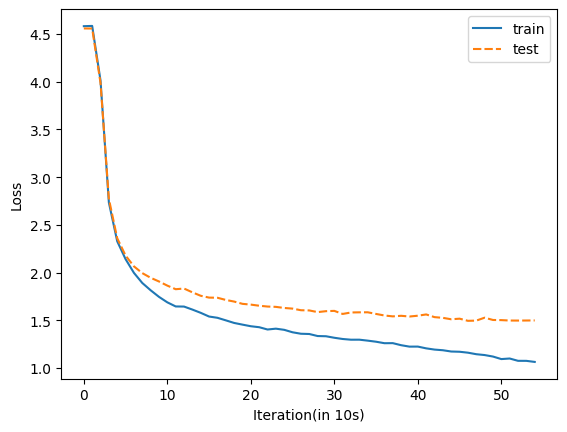

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
losses_df = pd.DataFrame(losses_data)
losses_df = losses_df.applymap(lambda x: float(x))
print(losses_df.head())
# Line graph of loss train and loss test
ax = sns.lineplot(data=losses_df[losses_df['train'] < 10])
ax.set(xlabel='Iteration(in 10s)', ylabel='Loss')
plt.show()